# Analysis of the gills
- Flu, David and Oleksiy scanned the fish heads
- Dea and Matthias delineated the gills
- Matthias provided the non-CT data in XLS sheets
- David wrote the whole analysis in this notebook

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
from matplotlib_scalebar.scalebar import ScaleBar
import platform
import os
import glob
import pandas
import numpy
import scipy.misc
# import skimage.filters
# import skimage.morphology
import gc
from tqdm import tqdm_notebook
import itertools
import scipy.stats
import imageio
import string

In [2]:
# Turn off warning in the notebook
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Style plots
seaborn.set_style('whitegrid')
seaborn.set_context('paper')

In [4]:
# Start all the plots at y=0
zerotheplots = False

In [5]:
# Display and output defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
# plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['savefig.dpi'] = 300  # Save (PNG) images with a higher DPI, since Authorea cannot import PDFs...
plt.rcParams["savefig.transparent"] = False

In [6]:
# Setup scale bar
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'
plt.rcParams['scalebar.scale_loc'] = 'top'

In [7]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [8]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [9]:
def whichexperiment(i):
    '''Categorize  into 'Swimmer' or 'Control' '''
    if 'immer' in i:
        return 'Swimmer'
    if 'ontrol' in i:
        return 'Control'

In [10]:
def color_based_on_experiment(i):
    '''Colorize into 'Swimmer' or 'Control' '''
    if 'ontrol' in i:
        return seaborn.color_palette()[0]
    if 'immer' in i:
        return seaborn.color_palette()[1]

In [11]:
def get_rec_gray_values(logfile):
    """Get the low and high value for the mapping of the reconstruction gray values"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Minimum for CS' in line:
                minimum = float(line.split('=')[1])
            if 'Maximum for CS' in line:
                maximum = float(line.split('=')[1])
    return(minimum, maximum)

In [12]:
def whodunit(logfile):
    """
    Who did the scan?
    https://en.wikipedia.org/wiki/Whodunit"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'User Name' in line:
                user = line.split('=')[1].rstrip()
    return(user)

In [13]:
def percentage(value1, value2):
    """
    We use this over and over in the results part.
    Just a helper function to print out the percentage increase.
    """
    p = value2 / value1
    p -= 1
    p *= 100
    return(p)

In [14]:
def significance(p):
    """
    Get some 'information' on the p-values we calculate.
    See the bottom of https://git.io/vQbWV
    """
    if (p < 0.001):
        return "***"
        # The function used to return ("*** (p=%0.2g)" % p),
        # but we try to reduce clutter in the plots and only specify the level now
    elif (p < 0.01):
        return "**"
    elif (p < 0.05):
        return "*"
    else:
        return "n.s."

In [15]:
def significance_bar(start, end, height, pvalue, markersize=25, boxpad=0, color='gray'):
    """ Draw significance bars, based on on https://stackoverflow.com/a/33873837/323100 """
    # Draw a line with downticks at the ends
    plt.plot([start, end],
             [1.05 * height] * 2,
             '-',
             color=color,
             marker=3,  # 3 == TICKDOWN: https://matplotlib.org/api/markers_api.html
             markersize=markersize)
    # Draw the text with semitransparent background in case we cover other plots
    plt.text(0.5 * (start + end),
             1.05 * height,
             '%s' % significance(pvalue),
             ha='center',
             va='bottom',
             bbox=dict(facecolor='white',
                       alpha=0.309,
                       edgecolor='none',
                       boxstyle='Square,pad=' + str(boxpad)))

In [16]:
# Work on the fast SSD from here on!
FastSSD = False
if 'debian' in platform.dist():
    if FastSSD:
        StartDir = '/media/habi/Fast_SSD/'
    else:
        StartDir = '/media/habi/Black Seagate/'
else:
    if FastSSD:
        StartDir = 'F:/'
    else:
        StartDir = 'G:/'
RootFolder = os.path.join(StartDir, 'Zebra-Fish_Matthias')

In [17]:
print('We are loading all the data from %s' % RootFolder)

We are loading all the data from /media/habi/Black Seagate/Zebra-Fish_Matthias


In [18]:
# Make directory for output
OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
print('We are saving all the output to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving all the output to /home/habi/P/Documents/Zebrafish-Gills/Output/99a07e1


In [19]:
# Display all plots identically
lines = 5
# And then do something like
# plt.subplot(lines, numpy.ceil(len(ROIFolder) / float(lines)), c + 1)

----
Load all the data from the microCT scans we need later on.

In [20]:
# Get all the 'Control' and 'Swimmer' folders in the root folder
# https://stackoverflow.com/a/34507323/323100
SampleNames = sorted(glob.glob(os.path.join(RootFolder, 'Control*')) + glob.glob(os.path.join(RootFolder, 'Swimmer*')))
SampleNames = [os.path.basename(sn) for sn in SampleNames]

In [21]:
# Reproducible research for everyone
if not len(SampleNames):
    print('You can dowload the datasets to fully reproduce our results.')
    print()
    print('Please go to https://osf.io/a5esx/ and download one zip file for each fish.')
    print('Unzipping these should give a folder for each fish (Control01 to 10 and Swimmer01 to 10).')
    print('Save all these folders somewhere and put "somewhere" into the "RootFolder" variable some cells above')
    print()
    print('In each of the folders you should have a "proj", "rec" and "VOI" folder.')
    print('In the "proj" folder you have the scan log file and an alignment image (BMP) from the scan.')
    print('In the "rec" folder you have the scan log file and an alignment image (BMP) from the scan.')
    print('In the "VOI" folder you have the delineated gills, which are the input for most of the analysis.')
    print('The .roi file lingering in the subfolder is the export of the delineated ROI from CTAn.')
    print()
    print('The .XLS sheets for the other data are versioned in the GitHub repository which you probably cloned.')

In [22]:
# Generate us an empty dataframe to put all the data into
Data = pandas.DataFrame()

In [23]:
# Save all the information into a pandas dataframe
Data['Sample'] = [sn for sn in SampleNames]
Data['Folder'] = [os.path.join(RootFolder, s) for s in SampleNames]
Data['LogFile'] = [sorted(glob.glob(os.path.join(f, 'proj', '*.log')))[0] for f in Data.Folder]
Data['RecFolder'] = [os.path.join(RootFolder, f, 'rec') for f in Data.Folder]
Data['VOIFolder'] = [os.path.join(RootFolder, f, 'VOI') for f in Data.Folder]
Data['OverviewName'] = [glob.glob(os.path.join(r, '*spr.bmp'))[0] for r in Data.RecFolder]
Data['ReconstructionNames'] = [sorted(glob.glob(os.path.join(r, '*.png'))) for r in Data.RecFolder]
# Try to be a bit clever with loading the VOI slices
# They are saved as either PNG or BMP, and there's also some other stuff in the folder...
Data['VOINames'] = [sorted(glob.glob(os.path.join(r, '*rec*[0123456789].*'))) for r in Data.VOIFolder]

In [24]:
# Swimmer or Control?
Data['Experiment'] = [whichexperiment(name) for name in Data.Folder]

In [25]:
# Colorize
Data['Color'] = [color_based_on_experiment(name) for name in Data.Folder]

In [26]:
# Get Pixel sizes of the scans
# in micrometers
Data['PixelSize'] = [get_pixelsize(logfile) for logfile in Data.LogFile]

In [27]:
# Who scanne which sample?
Data['ScanMaster'] = [whodunit(logfile) for logfile in Data.LogFile]

In [28]:
for exp in Data.Experiment.unique():
    print('We scanned %s %s fishes' % (len(Data[Data.Experiment == exp]), exp))

We scanned 10 Control fishes
We scanned 10 Swimmer fishes


In [29]:
print('From the %s samples we have' % len(Data))
for who in Data.ScanMaster.unique():
    print('\t- %s scanned %s samples' % (who, len(Data[Data.ScanMaster == who])))

From the 20 samples we have
	- khoma scanned 6 samples
	- haberthu scanned 6 samples
	- fw13i082 scanned 8 samples


In [30]:
# Get the reconstruction gray values mapping
Data['RecGrayValues'] = [get_rec_gray_values(logfile) for logfile in Data.LogFile]
Data['Rec Gray Min'] = [v[0] for v in Data['RecGrayValues']]
Data['Rec Gray Max'] = [v[1] for v in Data['RecGrayValues']]

In [31]:
# Double-check gray value mapping
# If nothing returned, all is good...
for c, row in Data.iterrows():
    if row['Rec Gray Min'] != 0:
        print('%s has a non-zero minimal reconstruction gray value, namely %0.3f (scanned by %s)' % (row.Sample,
                                                                                                     row['Rec Gray Min'],
                                                                                                     row.ScanMaster))

In [32]:
# Rec Gray Maximum
Data[['Sample', 'Rec Gray Max']][Data['Rec Gray Max'] == Data['Rec Gray Max'].max()]

,Sample,Rec Gray Max
5,Control06,0.538812


In [33]:
# The full head of Control06 was re-reconstructed for visualization purposes (Fig. 1)
# It thus has a differing gray value

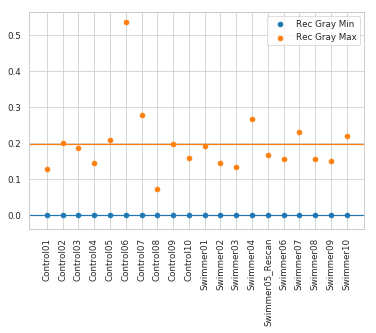

In [34]:
# Double-check gray value mapping
plt.scatter(Data.Sample, Data['Rec Gray Min'])
plt.axhline(Data['Rec Gray Min'].mean(), c=seaborn.color_palette()[0])
plt.scatter(Data.Sample, Data['Rec Gray Max'])
plt.axhline(Data['Rec Gray Max'].mean(), c=seaborn.color_palette()[1])
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.show()

In [35]:
# Calculate the voxel volume, which we'll use later on
# Let's use microlitre as unit
Data['VoxelVolume'] = [ps ** 3 * 1e-9 for ps in Data.PixelSize]

In [36]:
# Make ourselves a 'fish colum', which we need later on for merging different data frames
# (e.g. Gill volume and morphology)
Data['Fish'] = [int(n.split('_')[0][-2:]) for n in Data.Sample]

In [37]:
# Load Overview images
Overviews = [scipy.misc.imread(o, flatten=True) for o in Data.OverviewName]

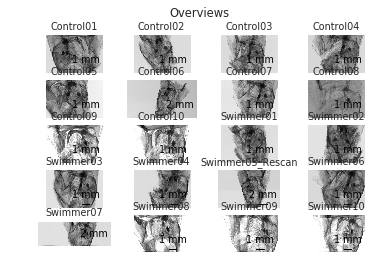

In [38]:
# Display overviews (shadow projections)
for c, o in enumerate(Overviews):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(o)
    plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um', color='black'))
    plt.axis('off')
    plt.title('%s' % Data.Sample[c])
plt.suptitle('Overviews')
plt.savefig(os.path.join(OutPutDir, 'Overviews.png'), bbox_inches='tight')
plt.show()

In [39]:
# Convert all VOI slices of each fish into single NumPy arrays and save them to disk
# But only do this if we didn't do it already :)
# Partially based on http://stackoverflow.com/a/39195332/323100
# Since we reload/memorymap the stack below, we overwrite the variable with NaN and clear the memory
Data['OutputNameVOI'] = [os.path.join(f, sample + '_VOI.npy') for f, sample in zip(Data.Folder, Data.Sample)]
# Don't save into the dataframe, or else we won't be able to make it :)
VOIImages = [numpy.nan for file in Data.OutputNameVOI]
for c, voi in enumerate(Data.OutputNameVOI):
    # Only do this if we didn't do it already...
    if os.path.exists(voi):
        print('%2s/%s: %16s: Already saved to %s' % (c + 1, len(Data.Sample), Data.Sample[c], voi[len(RootFolder):]))
    else:
        print('%2s/%s: %16s: Reading %4s VOI images' % (c + 1, len(Data.Sample), Data.Sample[c], len(Data.VOINames[c])))
        # Actually load the images now
        VOIImages[c] = numpy.array([scipy.misc.imread(i, flatten=True) for i in Data.VOINames[c]])
        # Save the images to NumPy binary files, disallowing pickle for portability
        print('%23s: Saving to %s' % (Data.Sample[c], voi))
        numpy.save(voi, VOIImages[c], allow_pickle=False)
        # Clear memory
        VOIImages[c] = numpy.nan
        gc.collect()

 1/20:        Control01: Already saved to /Control01/Control01_VOI.npy
 2/20:        Control02: Already saved to /Control02/Control02_VOI.npy
 3/20:        Control03: Already saved to /Control03/Control03_VOI.npy
 4/20:        Control04: Already saved to /Control04/Control04_VOI.npy
 5/20:        Control05: Already saved to /Control05/Control05_VOI.npy
 6/20:        Control06: Already saved to /Control06/Control06_VOI.npy
 7/20:        Control07: Already saved to /Control07/Control07_VOI.npy
 8/20:        Control08: Already saved to /Control08/Control08_VOI.npy
 9/20:        Control09: Already saved to /Control09/Control09_VOI.npy
10/20:        Control10: Already saved to /Control10/Control10_VOI.npy
11/20:        Swimmer01: Already saved to /Swimmer01/Swimmer01_VOI.npy
12/20:        Swimmer02: Already saved to /Swimmer02/Swimmer02_VOI.npy
13/20:        Swimmer03: Already saved to /Swimmer03/Swimmer03_VOI.npy
14/20:        Swimmer04: Already saved to /Swimmer04/Swimmer04_VOI.npy
15/20:

In [40]:
# Free the memory of the images we loaded.
# We 'memory-map' them again below
%xdel VOIImages

In [41]:
# Load (or memory-map) all the files.
# This is loading the images like a virtual stack in ImageJ
VOIImages = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]

In [42]:
# Get ourselves the middle slice to show
Data['MiddleSliceName'] = [n[len(n) // 2] for n in Data.VOINames]
Data['MiddleSlice'] = [i[len(i) // 2] for i in VOIImages]

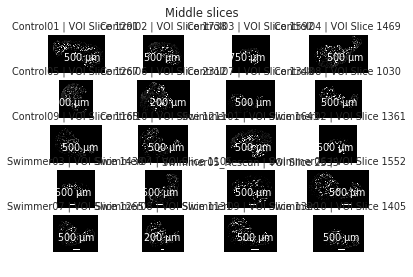

In [43]:
# Display the middle slice of the VOI
for c, m in enumerate(Data.MiddleSlice):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(m, vmax=0.618 * numpy.max(m))
    plt.title('%s | VOI Slice %s' % (Data.Sample[c], os.path.basename(Data.MiddleSliceName[c])[-8:-4]))
    plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
    plt.axis('off')
plt.suptitle('Middle slices')
# plt.savefig(os.path.join(OutPutDir, 'MiddleSlices.png'), bbox_inches='tight')
plt.show()

In [44]:
# Get ourselves some information on the VOI size
Data['NumberOfVOISlices'] = [len(v) for v in Data.VOINames]
Data['VOIShape'] = [voi.shape for voi in VOIImages]
Data['VOIVolume'] = [shape[0] * shape[1] * shape[2] for shape in Data.VOIShape]

In [45]:
# Check of VOI size and number of files is consistent.
# If there's no output from this cell, then everything is correct.
for c, row in Data.iterrows():
    if len(row.VOINames) != len(VOIImages[c]):
        print(row.Sample)
        print(len(row.VOINames))
        print(row.VOIShape[0])
        print(len(VOIImages[c]))
        print(80 * '-')

In [46]:
# Average volume/size
print('The average VOI site is a cube '
      'with a side length of %s pixels' % int(round(Data.VOIVolume.mean() ** (1 / 3.))))

The average VOI site is a cube with a side length of 1863 pixels


In [47]:
# For bragging reasons in the manuscript
# 'sort_values' does an ascending sort by default, so let's look at the biggest (last/'tail(1)') item
print('The largest VOI is')
print(Data[['Sample', 'VOIVolume', 'NumberOfVOISlices', 'VOIShape']].sort_values('VOIVolume').tail(1))
print(80 * '-')
# 'sort_values' does an ascending sort by default, so let's look at the smallest (first/'head(1)') item
print('The smallest VOI is')
print(Data[['Sample', 'VOIVolume', 'NumberOfVOISlices', 'VOIShape']].sort_values('VOIVolume').head(1))

The largest VOI is
      Sample    VOIVolume  NumberOfVOISlices            VOIShape
2  Control03  15639764080               2455  (2455, 2524, 2524)
--------------------------------------------------------------------------------
The smallest VOI is
      Sample   VOIVolume  NumberOfVOISlices            VOIShape
5  Control06  3549969500               2300  (2300, 1045, 1477)


In [48]:
# Use a manageable amount of equally spaced slices for thresholding and MIP-ing
# This was done in the evaluation stage of the notebook for speed-up reasons
# NumberOfImagesToShow = 15
# NumberOfImagesToShow = 111
# NumberOfImagesToShow = 350
# NumberOfImagesToShow = 1111
# For the finalized version, we just use *all* the slices we have
NumberOfImagesToShow = Data.NumberOfVOISlices.max()

In [49]:
# Generate the subset information
Data['PrintEverySlice'] = [int(round(len(r) / NumberOfImagesToShow)) for r in Data.VOINames]
Data['SubsetNames'] = [rn[::sw] for rn, sw in zip(Data.VOINames, Data.PrintEverySlice)]
for c, i in enumerate(Data.Sample):
    print('For %s we are working with a subset of %s (%0.1f %% of totally %s) equally '
          'spaced slices' % (i,
                             len(Data.SubsetNames[c]),
                             len(Data.SubsetNames[c]) / len(Data.VOINames[c]) * 100,
                             len(Data.VOINames[c])))

For Control01 we are working with a subset of 2338 (100.0 % of totally 2338) equally spaced slices
For Control02 we are working with a subset of 1990 (100.0 % of totally 1990) equally spaced slices
For Control03 we are working with a subset of 2455 (100.0 % of totally 2455) equally spaced slices
For Control04 we are working with a subset of 2187 (100.0 % of totally 2187) equally spaced slices
For Control05 we are working with a subset of 2388 (100.0 % of totally 2388) equally spaced slices
For Control06 we are working with a subset of 2300 (100.0 % of totally 2300) equally spaced slices
For Control07 we are working with a subset of 2452 (100.0 % of totally 2452) equally spaced slices
For Control08 we are working with a subset of 2056 (100.0 % of totally 2056) equally spaced slices
For Control09 we are working with a subset of 2327 (100.0 % of totally 2327) equally spaced slices
For Control10 we are working with a subset of 2416 (100.0 % of totally 2416) equally spaced slices
For Swimme

In [50]:
# Put length of 'UseThis' into dataframe
Data['NumberOfAnalyzedVOISlices'] = [len((a)) for a in Data.SubsetNames]

----
Load the Excel-sheets with data from Matthias and Helena, scattered in different XLS files.

In [51]:
# Load the fish length data
morphologyfile = glob.glob(os.path.join('XLS*', '*morph*.xlsx'))[0]
# Load all the morphology data into its own dataframe
# With a hat tip to https://stackoverflow.com/a/49442625/323100
Morphology = pandas.read_excel(morphologyfile,
                               usecols='E:H,K:N',
                               skiprows=3,
                               nrows=27,
                               names=['Length Swimmer Before',
                                      'Weight Swimmer Before',
                                      'Length Control Before',
                                      'Weight Control Before',
                                      'Length Swimmer After',
                                      'Weight Swimmer After',
                                      'Length Control After',
                                      'Weight Control After'])
# Drop unneeded rows
Morphology.drop([10, 11, 12, 13, 14, 15, 16], inplace=True)
# Get ourselves the fish number in a column
Morphology['Fish'] = range(1, 21)
Morphology['Fish'][10:] = range(1, 11)
# Get ourselves the gender in a column
Morphology['Gender'] = 'Female'
Morphology['Gender'][10:] = 'Male'

In [52]:
# Massage the morphology data into a new dataframe for displaying it nicely
# One fish for the swimmers after training died, so we temporarily
# replace it's data with 9999 to we can still do the 'dropna' dance below
Morphology.fillna(value=9999, inplace=True)
# First, pull together so we get a proper 'Training' column
mo = pandas.concat([Morphology[['Gender',
                                'Fish',
                                'Length Control Before',
                                'Length Swimmer Before',
                                'Weight Control Before',
                                'Weight Swimmer Before']],
                    Morphology[['Gender',
                                'Fish',
                                'Length Control After',
                                'Length Swimmer After',
                                'Weight Control After',
                                'Weight Swimmer After']]])

mo['Length Control'] = pandas.concat([mo['Length Control Before'].dropna(),
                                      mo['Length Control After'].dropna()])
mo['Length Swimmer'] = pandas.concat([mo['Length Swimmer Before'].dropna(),
                                      mo['Length Swimmer After'].dropna()])
mo['Weight Control'] = pandas.concat([mo['Weight Control Before'].dropna(),
                                      mo['Weight Control After'].dropna()])
mo['Weight Swimmer'] = pandas.concat([mo['Weight Swimmer Before'].dropna(),
                                      mo['Weight Swimmer After'].dropna()])
mo['Training'] = ['Before' if o > 0 else 'After' for o in mo['Length Control Before']]
# Then, pull together so we get a proper 'Experiment' column
mo2 = pandas.concat([mo[['Gender',
                         'Fish',
                         'Training',
                         'Length Control',
                         'Weight Control']],
                     mo[['Gender',
                         'Fish',
                         'Training',
                         'Length Swimmer',
                         'Weight Swimmer']]])
mo2['Length'] = pandas.concat([mo2['Length Control'].dropna(),
                               mo2['Length Swimmer'].dropna()])
mo2['Weight'] = pandas.concat([mo2['Weight Control'].dropna(),
                               mo2['Weight Swimmer'].dropna()])
mo2['Experiment'] = ['Swimmer' if i > 0 else 'Control' for i in mo2['Length Swimmer']]
# Set that one fish back to NaN
mo2.replace(9999, numpy.nan, inplace=True)
# Set the massaged data back to the Morphology dataframe
Morphology = mo2

In [53]:
# Merge (correct) morphology data into the other data
# We need that later on for normalizing calculated values to the fish length
Data = pandas.merge(Data,
                    Morphology[(Morphology.Gender == 'Female')
                               & (Morphology.Training == 'After')])

In [54]:
# Load the respirometry data
# Since it's in a 'messy' xls sheet, we cannot do it in one go, but do it in four cells :)
respirometryfile = glob.glob(os.path.join('XLS*', '*', 'Respirometry*.xlsx'))[0]
# Based on https://stackoverflow.com/a/49442625/323100
# Load O2 at start
o2 = pandas.read_excel(respirometryfile, index_col=None, skiprows=1, usecols='H')
Data['O2 consumption start'] = pandas.concat([o2], ignore_index=True)

In [55]:
# Load O2 at start, normalized
o2_norm = pandas.read_excel(respirometryfile, index_col=None, skiprows=1, usecols='I')
# Unfortunately, Matthias saved some more stuff into this colum, so we just drop some cells
o2_norm.drop([10, 21, 22], inplace=True)
Data['O2 consumption start normalized'] = pandas.concat([o2_norm], ignore_index=True)

In [56]:
# Load O2 at the end
o2_end = pandas.read_excel(respirometryfile, index_col=None, skiprows=1, usecols='P')
Data['O2 consumption end'] = pandas.concat([o2_end], ignore_index=True)

In [57]:
# Load O2 at end, normalized
o2_norm_end = pandas.read_excel(respirometryfile, index_col=None, skiprows=1, usecols='Q')
# Unfortunately, Matthias saved some more stuff into this colum, so we just drop some cells
o2_norm_end.drop([10, 20], inplace=True)
Data['O2 consumption end normalized'] = pandas.concat([o2_norm_end], ignore_index=True)

In [58]:
# Double-check the data
# Data[['Sample',
#       'O2 consumption start', 'O2 consumption start normalized',
#       'O2 consumption end', 'O2 consumption end normalized']]

In [59]:
# Massage the respirometry data into a new dataframe for displaying it nicely
# On some respirometry data we have NaN.
# Let's fill this with 9999, so that we can merge the before/after data
Data.fillna(value=9999, inplace=True)
# Generate us a new dataframe
Respirometry = pandas.concat([Data[['Sample', 'Experiment', 'O2 consumption start normalized']],
                              Data[['Sample', 'Experiment', 'O2 consumption end normalized']]])
# Let's put NaN back
Data.replace(9999, numpy.nan, inplace=True)
# Merge, based on https://stackoverflow.com/a/10972557/323100
Respirometry['o2'] = pandas.concat([Respirometry['O2 consumption start normalized'].dropna(),
                                    Respirometry['O2 consumption end normalized'].dropna()])
# Make us an experiment state, so we can 'hue' on this later
Respirometry['Training'] = ['Before' if o > 0 else 'After' for o in Respirometry['O2 consumption start normalized']]
# Set that one value back to NaN
Respirometry.replace(9999, numpy.nan, inplace=True)

In [60]:
# Load the SEM data
semfile = glob.glob(os.path.join('XLS*', '*', '*electron*.xlsx'))[0]
# Load filament count
# We could probably do it in one go as above, but then 'squeeze' doesn't seem to discard the empty lines...
Filaments = pandas.DataFrame()
Filaments['Swimmer Count'] = pandas.read_excel(semfile, usecols='G', nrows=199, squeeze=True)
Filaments['Control Count'] = pandas.read_excel(semfile, usecols='AA', nrows=199, squeeze=True, na_values='Keine Daten')
# Load filament length
Filaments['Swimmer Length'] = pandas.read_excel(semfile, usecols='Q', nrows=199, squeeze=True)
Filaments['Control Length'] = pandas.read_excel(semfile, usecols='AK', nrows=199, squeeze=True, na_values='Keine Daten')
# Scale from Fiji measurement units to um
Filaments['Swimmer Length'] *= 1 / 0.6 * 100
Filaments['Control Length'] *= 1 / 0.6 * 100

In [61]:
# Load the speed assessment data
speedfile = glob.glob(os.path.join('XLS*', 'Critical speed*.xlsx'))[0]
# Load two empty colums (G, H) for dummy data ('Control 3wk' and 'Control rpm 3wk')
Speed = pandas.read_excel(speedfile,
                          usecols='B,C,E,F,G,H,O,P,R,S,U,V',
                          skiprows=3,
                          nrows=29,
                          names=['Swimmer Before',
                                 'Swimmer rpm Before',
                                 'Control Before',
                                 'Control rpm Before',
                                 'Control 3wk',
                                 'Control rpm 3wk',
                                 'Swimmer 3wk',
                                 'Swimmer rpm 3wk',
                                 'Swimmer After',
                                 'Swimmer rpm After',
                                 'Control After',
                                 'Control rpm After'])
# Drop unneeded colums and reset the numbering (index)
Speed.drop([10, 11, 12, 13, 14, 15, 16, 17, 18], inplace=True)
Speed.reset_index(inplace=True, drop=True)
# Convert the weird Excel time to something we can actually use...
# Pandas parses the M:S Matthias entered as H:M:00
# It would probably be easy to do this via a parser, but just converting it with a Timedelta is quicker.
# (Which actually just means I gave up after putting keywords into a search engine for two hours...)
Speed['Swimmer Before'] = [pandas.Timedelta(minutes=time.hour,
                                            seconds=time.minute) for time in Speed['Swimmer Before']]
Speed['Control Before'] = [pandas.Timedelta(minutes=time.hour,
                                            seconds=time.minute) for time in Speed['Control Before']]
# Since we have NaN (as float) in the column (data for fish 10 is missing)
# we jump through this super-complicated hoop to covert the time to timedelta so that we have NaT
# with a tip to the hat to https://stackoverflow.com/a/25142407/323100
Speed['Swimmer 3wk'] = [pandas.Timedelta(minutes=time.hour, seconds=time.minute)
                        if not pandas.isnull(time) else pandas.to_datetime('13000101',
                                                                           format='%Y%m%d',
                                                                           errors='coerce')
                        for time in Speed['Swimmer 3wk']]
Speed['Swimmer After'] = [pandas.Timedelta(minutes=time.hour, seconds=time.minute)
                          if not pandas.isnull(time) else pandas.to_datetime('13000101',
                                                                             format='%Y%m%d',
                                                                             errors='coerce')
                          for time in Speed['Swimmer After']]
Speed['Control After'] = [pandas.Timedelta(minutes=time.hour,
                                           seconds=time.minute) for time in Speed['Control After']]
# Get ourselves the fish number in a column
Speed['Fish'] = range(1, 21)
Speed['Fish'][10:] = range(1, 11)
# Get ourselves the gender in a column
Speed['Gender'] = 'Female'
Speed['Gender'][10:] = 'Male'
# Fill the dummy colums with dummy values
Speed['Control 3wk'] = pandas.Timedelta(minutes=99)
Speed['Control rpm 3wk'] = 13
# We don't need the RPM data at the moment, so we just drop it again...
for i in Speed:
    if 'rpm' in i:
        Speed.drop(i, axis=1, inplace=True)

In [62]:
# After discussion with Helena we need to convert the 
# total swimming time to a water-speed step function
speedconversionfile = glob.glob(os.path.join('XLS*', 'converting*.xlsx'))[0]
SpeedConversion = pandas.read_excel(speedconversionfile,
                                    skiprows=2)
SpeedConversion

,time from [s],time up to [s],speed of water current [cm/s]
0,0,120,5
1,121,240,10
2,241,360,15
3,361,480,20
4,481,600,25
5,601,720,30
6,721,840,35
7,841,960,40
8,961,1080,45
9,1081,1200,50


In [63]:
# Convert Helenas table into a function.
# for i in range(12):
#     print('From %04s to %04s, we set the speed to %02s' % (120*i+1,
#                                                            120*(i+1),
#                                                            5*(i+1)))
# Instead of trying to parse the speedtable from Helena
# we can just apply this function to the time and get the speed of the current
def time_to_speed(time):
    speed = 5 * (((time - 1) // 120) + 1)
    return(speed)

In [64]:
# Massage the speed data into a new dataframe for displaying it nicely
# One fish for the swimmers after training died missing,
# replace it's data with 9999 so we can still do the 'dropna' dance below
Speed.fillna(value=9999, inplace=True)
# First, pull together so we get a proper 'Training' column
sp = pandas.concat([Speed[['Gender',
                           'Fish',
                           'Control Before',
                           'Swimmer Before']],
                    Speed[['Gender',
                           'Fish',
                           'Control 3wk',
                           'Swimmer 3wk']],
                    Speed[['Gender',
                           'Fish',
                           'Control After',
                           'Swimmer After']]])
sp['Control'] = pandas.concat([sp['Control Before'].dropna(),
                               sp['Control 3wk'].dropna(),
                               sp['Control After'].dropna()])
sp['Swimmer'] = pandas.concat([sp['Swimmer Before'].dropna(),
                               sp['Swimmer 3wk'].dropna(),
                               sp['Swimmer After'].dropna()])
# Make us a 'Training' column
sp['Training'] = 'Before'
# https://stackoverflow.com/a/12307162/323100
sp.loc[sp['Swimmer 3wk'] > pandas.Timedelta(seconds=1), 'Training'] = '3 wk'
sp.loc[sp['Swimmer After'] > pandas.Timedelta(seconds=1), 'Training'] = '5 wk'
# Then, pull together so we get a proper 'Experiment' column
sp2 = pandas.concat([sp[['Gender',
                         'Fish',
                         'Training',
                         'Control']],
                     sp[['Gender',
                         'Fish',
                         'Training',
                         'Swimmer']]])
sp2['Time'] = pandas.concat([sp2['Control'].dropna(),
                             sp2['Swimmer'].dropna()])
sp2['Experiment'] = ['Swimmer' if i > pandas.Timedelta(seconds=0) else 'Control' for i in sp2['Swimmer']]
# Set the special values back to NaT/NaN
sp2.replace(pandas.Timedelta(seconds=9999.), numpy.nan, inplace=True)
sp2.replace(pandas.Timedelta(seconds=5940.), numpy.nan, inplace=True)
# Set the massaged data back to the Morphology dataframe
Speed = sp2
# Make us a 'total seconds' column for plotting later on
Speed['Seconds'] = [t.total_seconds() for t in Speed.Time]
# Apply the step function
Speed['WaterSpeed'] = [time_to_speed(time) for time in Speed['Seconds']]

In [65]:
# Load mitosis data
mitosisfile = glob.glob(os.path.join('XLS*', 'mitoses*.xlsx'))[0]
Mitoses = pandas.read_excel(mitosisfile,
                            usecols='A, B, C',
                            skiprows=1)
# Add experiment column
Mitoses['Experiment'] = 'Control'
Mitoses['Experiment'][27:] = 'Swimmer'
# Drop empty/unneeded rows
Mitoses.drop([12, 25, 26, 27, 28, 41, 54], inplace=True)
# Calculate the value ourselves, it should be the the same as column E
Mitoses['M_per_N'] = (Mitoses['mitoses'] / Mitoses['nuclei']).astype('float')

In [66]:
# Confirm that we have the right numbers
Mitoses.groupby(by='Experiment').describe()

M_per_N                                                    \
             count      mean       std       min       25%       50%   
Experiment                                                             
Control       24.0  0.120570  0.076631  0.000000  0.063294  0.103930   
Swimmer       24.0  0.192309  0.115539  0.012245  0.116607  0.198356   

                                
                 75%       max  
Experiment                      
Control     0.198553  0.236994  
Swimmer     0.252702  0.401163

We have all the supporting data.
Now we start with the actual image processing

In [67]:
# Calculate the thresholds on each and every image
Data['OutputNameThreshold'] = [os.path.join(f,
                                            sample + '_thresholds_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                   len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
Data['Threshold'] = [[numpy.nan] for s in Data.Sample]
for c, thresholdname in enumerate(Data.OutputNameThreshold):
    if os.path.exists(thresholdname):
        print('%2s/%s: %16s: Grab values from %s' % (c + 1,
                                                     len(Data),
                                                     Data.Sample[c],
                                                     thresholdname[len(RootFolder):]))
        Data['Threshold'][c] = numpy.load(thresholdname)
    else:
        print('%2s/%s: %16s: Calculating thresholds for %s of %4s files' % (c + 1,
                                                                            len(Data),
                                                                            Data.Sample[c],
                                                                            len(Data.VOINames[c][::Data.PrintEverySlice[c]]),
                                                                            len(Data.VOINames[c])))
        Data['Threshold'][c] = [numpy.nan] * len(Data.VOINames[c][::Data.PrintEverySlice[c]])
        for d, image in tqdm_notebook(enumerate(VOIImages[c][::Data.PrintEverySlice[c]]),
                                      total=len(Data.VOINames[c]),
                                      leave=False):
            try:
                # Calculate and save threshold (of only the image, e.g. img[img>0])
                Data['Threshold'][c][d] = skimage.filters.threshold_otsu(image[image > 0])
            except (ValueError):
                # Save NaN if we can't calculate a threshold
                Data['Threshold'][c][d] = numpy.nan
        print('%23s: Saving thresholds to %s' % (Data.Sample[c], thresholdname[len(RootFolder):]))
        numpy.save(thresholdname, Data.Threshold[c], allow_pickle=False)
        Data.Threshold[c] = numpy.nan
        # Unmap current VOIImage: https://stackoverflow.com/a/6398543
        VOIImages[c]._mmap.close()
        gc.collect()

 1/20:        Control01: Grab values from /Control01/Control01_thresholds_from_2338_of_2338_slices.npy
 2/20:        Control02: Grab values from /Control02/Control02_thresholds_from_1990_of_1990_slices.npy
 3/20:        Control03: Grab values from /Control03/Control03_thresholds_from_2455_of_2455_slices.npy
 4/20:        Control04: Grab values from /Control04/Control04_thresholds_from_2187_of_2187_slices.npy
 5/20:        Control05: Grab values from /Control05/Control05_thresholds_from_2388_of_2388_slices.npy
 6/20:        Control06: Grab values from /Control06/Control06_thresholds_from_2300_of_2300_slices.npy
 7/20:        Control07: Grab values from /Control07/Control07_thresholds_from_2452_of_2452_slices.npy
 8/20:        Control08: Grab values from /Control08/Control08_thresholds_from_2056_of_2056_slices.npy
 9/20:        Control09: Grab values from /Control09/Control09_thresholds_from_2327_of_2327_slices.npy
10/20:        Control10: Grab values from /Control10/Control10_thresholds

In [68]:
# Load (or memory-map) all the VOI images again, since we closed them above
# This is loading the images like a virtual stack in ImageJ
VOIImages = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]

In [69]:
# Load (or memory-map) all the files.
# This is loading the images like a virtual stack in ImageJ
Data['Threshold'] = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameThreshold]

In [70]:
# Let's calculate the max, mean and median threshold for each sample
Data['ThresholdMax'] = [numpy.nanmax(t) for t in Data.Threshold]
# Discard the first and last $discard slices for the averaging
discard = 150
Data['ThresholdAverage'] = [numpy.nanmean(t[discard:-discard]) for t in Data.Threshold]
Data['ThresholdMedian'] = [numpy.nanmedian(t) for t in Data.Threshold]

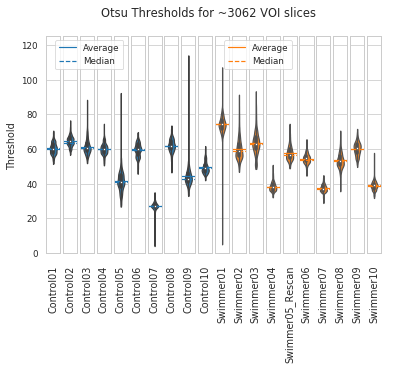

In [71]:
# Plot the Thresholds
for c, i in enumerate(Data.Threshold):
    plt.subplot(1, len(Data), c + 1)
    seaborn.violinplot(i[discard:-discard], orient='v', color=Data.Color[c], cut=0, width=0.5)
    plt.axhline(Data.ThresholdAverage[c], label='Average', color=Data.Color[c])
    plt.axhline(Data.ThresholdMedian[c], label='Median', color=Data.Color[c], ls='dashed')
    plt.ylim([0, Data.ThresholdMax.max() * 1.1])
    if c:
        plt.gca().axes.yaxis.set_ticklabels([])
    else:
        plt.ylabel('Threshold')
    if '05' in Data.Sample[c]:
        plt.legend()
    plt.xlabel(Data.Sample[c], rotation=90)
plt.suptitle('Otsu Thresholds for ~%s VOI slices' % NumberOfImagesToShow)
# plt.savefig(os.path.join(OutPutDir, 'Thresholds_from%04dslices.png' % NumberOfImagesToShow), bbox_inches='tight')
plt.show()

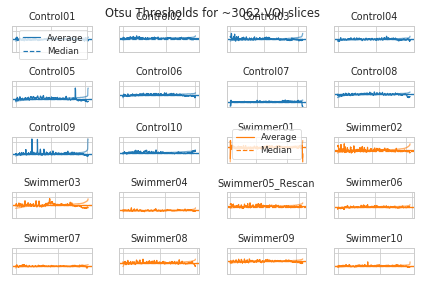

In [72]:
# Plot all the single thresholds
for c, i in enumerate(Data.Threshold):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.plot(i[discard:-discard], color=Data.Color[c])
    plt.plot(sorted(i[discard:-discard]), color=Data.Color[c], alpha=0.618)
    plt.axhline(Data.ThresholdAverage[c], label='Average', color=Data.Color[c])
    plt.axhline(Data.ThresholdMedian[c], label='Median', color=Data.Color[c], ls='dashed')
    plt.ylim([0, Data.ThresholdMax.max() * 1.1])
    plt.title(Data.Sample[c])
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])
    if '01' in Data.Sample[c]:
        plt.legend()
plt.suptitle('Otsu Thresholds for ~%s VOI slices' % NumberOfImagesToShow)
plt.tight_layout()
# plt.savefig(os.path.join(OutPutDir, 'Thresholds-plot_from%04dslices.png' % NumberOfImagesToShow), bbox_inches='tight')
plt.show()

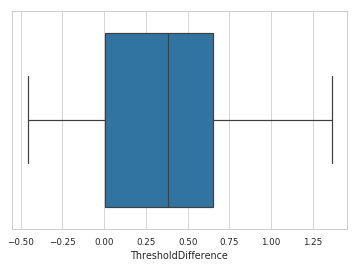

In [73]:
# Let's see if we should use the average or median
Data['ThresholdDifference'] = [numpy.subtract(a,m) for a,m in zip(Data.ThresholdAverage,
                                                                  Data.ThresholdMedian)]
Data[['Sample', 'ThresholdAverage', 'ThresholdMedian', 'ThresholdDifference']]
seaborn.boxplot(Data['ThresholdDifference'])
# Average and median are nearly the same, so let's keep using the average
plt.show()

In [74]:
# Read a subset of images
Data['OutputNameVOISubset'] = [os.path.join(f,
                                            sample + '_VOI_subset_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                   len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
# Don't save into the dataframe, or else we won't be able to make it to the end :)
VOISubset = [numpy.nan for file in Data.OutputNameVOISubset]
for c, subset in enumerate(Data.OutputNameVOISubset):
    if len(Data.VOINames[c]) != len(Data.VOINames[c][::Data.PrintEverySlice[c]]):
        # We are using a subset
        # Only do this if we didn't do it already...
        if os.path.exists(subset):
            print('%2s/%s: %16s: Already saved to %s' % (c + 1,
                                                         len(Data.Sample),
                                                         Data.Sample[c],
                                                         subset[len(RootFolder):]))
        else:
            print('%2s/%s: %16s: Subsetting %s of %s VOI images' % (c + 1,
                                                                    len(Data.Sample),
                                                                    Data.Sample[c],
                                                                    len(Data.SubsetNames[c]),
                                                                    len(Data.VOINames[c])))
            VOISubset[c] = [numpy.nan] * len(Data.VOINames[c][::Data.PrintEverySlice[c]])
            for d, image in enumerate(VOIImages[c][::Data.PrintEverySlice[c]]):
                VOISubset[c][d] = image
            print('%23s: Saving subset to %s' % (Data.Sample[c],
                                                 subset[len(RootFolder):]))
            numpy.save(subset, VOISubset[c], allow_pickle=False)
            VOISubset[c] = numpy.nan
            gc.collect()
    else:
        # We are using the full dataset
        print('%2s/%s: %16s: Using the full dataset' % (c + 1,
                                                        len(Data.Sample),
                                                        Data.Sample[c]))

 1/20:        Control01: Using the full dataset
 2/20:        Control02: Using the full dataset
 3/20:        Control03: Using the full dataset
 4/20:        Control04: Using the full dataset
 5/20:        Control05: Using the full dataset
 6/20:        Control06: Using the full dataset
 7/20:        Control07: Using the full dataset
 8/20:        Control08: Using the full dataset
 9/20:        Control09: Using the full dataset
10/20:        Control10: Using the full dataset
11/20:        Swimmer01: Using the full dataset
12/20:        Swimmer02: Using the full dataset
13/20:        Swimmer03: Using the full dataset
14/20:        Swimmer04: Using the full dataset
15/20: Swimmer05_Rescan: Using the full dataset
16/20:        Swimmer06: Using the full dataset
17/20:        Swimmer07: Using the full dataset
18/20:        Swimmer08: Using the full dataset
19/20:        Swimmer09: Using the full dataset
20/20:        Swimmer10: Using the full dataset


In [75]:
# Clear the memory
%xdel VOISubset

In [76]:
# Load (or memory-map) all the files.
if Data.PrintEverySlice[0] == 1:
    # If we did NOT use a subset, load the original stack...
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]
else:
    # If we did use a subset, then load the subset
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOISubset]

In [77]:
# Get the longest samplename, for display reasons below
# Based on https://stackoverflow.com/a/21295630/323100
namelenmax = Data.Sample.str.len().max()

In [78]:
# Use one threshold for all images (UseAverageThreshold=True, ThresholdAverage)
# Or use the Otsu threshold for each and every image (UseAverageThreshold=False)
UseAverageThreshold = False

In [79]:
# Actually threshold the images
if UseAverageThreshold:
    Data['OutputNameThresholded'] = [os.path.join(f,
                                                  sample + '_gills_thresholded-with-%0.2f.npy' % ta)
                                     for f, sample, ta in zip(Data.Folder,
                                                              Data.Sample,
                                                              Data.ThresholdAverage)]
else:
    Data['OutputNameThresholded'] = [os.path.join(f,
                                                  sample + '_gills_thresholded-slicewise.npy')
                                     for f, sample in zip(Data.Folder,
                                                          Data.Sample)]
Thresholded = [numpy.nan for file in Data.OutputNameThreshold]
for c, sample in Data.iterrows():
    # Only do this if we didn't do it already...
    if os.path.exists(sample.OutputNameThresholded):
        print('%2s/%s: %s: Already saved to %s' % (c + 1,
                                                   len(Data.Sample),
                                                   sample.Sample.rjust(namelenmax),
                                                   os.path.basename(sample.OutputNameThresholded)))
    else:
        if UseAverageThreshold:
            print('%2s/%s: %s: Thresholding %3s VOI images with %0.2f' % (c + 1,
                                                                          len(Data.Sample),
                                                                          sample.Sample.rjust(namelenmax),
                                                                          len(sample.VOINames),
                                                                          sample.ThresholdAverage))
        else:
            print('%2s/%s: %s: Thresholding %3s VOI images slicewise' % (c + 1,
                                                                         len(Data.Sample),
                                                                         sample.Sample.rjust(namelenmax),
                                                                         len(sample.VOINames)))
        Thresholded[c] = [None] * len(sample.VOINames)
        for d, image in tqdm_notebook(enumerate(VOISubset[c]),
                                      total=len(VOISubset[c]),
                                      leave=False):
            if UseAverageThreshold:
                Thresholded[c][d] = image > sample.Threshold[d]
            else:
                Thresholded[c][d] = image > sample.ThresholdAverage
        # Save the images to NumPy binary files, disallowing pickle for portability
        print('%s: Saving to %s' % (os.path.basename(sample.Sample.rjust(namelenmax + 7)),
                                    sample.OutputNameThresholded[len(RootFolder):]))
        numpy.save(sample.OutputNameThresholded, Thresholded[c], allow_pickle=False)
        Thresholded[c] = numpy.nan
        # Unmap current VOISubset: https://stackoverflow.com/a/6398543
        VOISubset[c]._mmap.close()
        gc.collect()
if UseAverageThreshold:
    print('\n\nWe were using a single threshold (ThresholdAverage) for *all* the images')
else:
    print('\n\nWe were using the Otsu threshold for each and every single image')

 1/20:        Control01: Already saved to Control01_gills_thresholded-slicewise.npy
 2/20:        Control02: Already saved to Control02_gills_thresholded-slicewise.npy
 3/20:        Control03: Already saved to Control03_gills_thresholded-slicewise.npy
 4/20:        Control04: Already saved to Control04_gills_thresholded-slicewise.npy
 5/20:        Control05: Already saved to Control05_gills_thresholded-slicewise.npy
 6/20:        Control06: Already saved to Control06_gills_thresholded-slicewise.npy
 7/20:        Control07: Already saved to Control07_gills_thresholded-slicewise.npy
 8/20:        Control08: Already saved to Control08_gills_thresholded-slicewise.npy
 9/20:        Control09: Already saved to Control09_gills_thresholded-slicewise.npy
10/20:        Control10: Already saved to Control10_gills_thresholded-slicewise.npy
11/20:        Swimmer01: Already saved to Swimmer01_gills_thresholded-slicewise.npy
12/20:        Swimmer02: Already saved to Swimmer02_gills_thresholded-slicew

In [80]:
# Load (or memory-map) all the files again.
if Data.PrintEverySlice[0] == 1:
    # If we did NOT use a subset, load the original stack...
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]
else:
    # If we did use a subset, then load the subset
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOISubset]

In [81]:
# Load (or memory-map) all the files again.
Thresholded = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameThresholded]

In [82]:
# # Display middle slices and thresholded equivalent
# for c, fish in Data.iterrows():
#     plt.subplot(121)
#     plt.imshow(VOIImages[c][len(VOIImages[c]) // 2])
#     plt.title('%s: Middle slice (...%s)' % (fish.Sample, Data.VOINames[c][len(VOIImages[c]) // 2][-12:]))
#     plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
#     plt.axis('off')
#     plt.subplot(122)
#     plt.imshow(Thresholded[c][len(Thresholded[c]) // 2])
#     plt.title('Thresholded with %0.2f' % Data.ThresholdAverage[c])
#     plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
#     plt.axis('off')
#     plt.savefig(os.path.join(OutPutDir, 'MiddleSlice.%s.png' % fish.Sample), bbox_inches='tight')
#     plt.show()

In [83]:
# Save thresholded images out
SaveImages = True
if SaveImages:
    # Save thresholded images
    for c, folder in enumerate(Data.VOIFolder):
        CurrentOutputFolder = os.path.splitext(Data.OutputNameThresholded[c])[0].replace(Data.Sample[c] + '_gills', 'VOI_gills')
        if not os.path.exists(CurrentOutputFolder):
            os.makedirs(CurrentOutputFolder)
        if len(glob.glob(os.path.join(CurrentOutputFolder, '*.png'))) >= len(VOIImages[c]):
            print('%2s/%s: %s: Already saved %s thresholded images to %s' % (c + 1,
                                                                             len(Data),
                                                                             Data.Sample[c].rjust(namelenmax),
                                                                             len(VOIImages[c]),
                                                                             CurrentOutputFolder[len(RootFolder) + 1:]))
        else:
            print('%2s/%s: %s: Saving %s thresholded images to %s' % (c + 1,
                                                                      len(Data),
                                                                      Data.Sample[c].rjust(namelenmax),
                                                                      len(Thresholded[c]),
                                                                      CurrentOutputFolder[len(RootFolder) + 1:]))
            for d, i in tqdm_notebook(enumerate(Thresholded[c]),
                                      total=len(Thresholded[c]),
                                      leave=False):
                scipy.misc.imsave(os.path.join(CurrentOutputFolder,
                                               Data.Sample[c] + '_thresholded_%04d.png' % d), i.astype('uint8') * 255)

 1/20:        Control01: Already saved 2338 thresholded images to Control01/VOI_gills_thresholded-slicewise
 2/20:        Control02: Already saved 1990 thresholded images to Control02/VOI_gills_thresholded-slicewise
 3/20:        Control03: Already saved 2455 thresholded images to Control03/VOI_gills_thresholded-slicewise
 4/20:        Control04: Already saved 2187 thresholded images to Control04/VOI_gills_thresholded-slicewise
 5/20:        Control05: Already saved 2388 thresholded images to Control05/VOI_gills_thresholded-slicewise
 6/20:        Control06: Already saved 2300 thresholded images to Control06/VOI_gills_thresholded-slicewise
 7/20:        Control07: Already saved 2452 thresholded images to Control07/VOI_gills_thresholded-slicewise
 8/20:        Control08: Already saved 2056 thresholded images to Control08/VOI_gills_thresholded-slicewise
 9/20:        Control09: Already saved 2327 thresholded images to Control09/VOI_gills_thresholded-slicewise
10/20:        Control10: Alr

In [84]:
# # Display some original slices through the VOIs
# SlicesToShow = 5
# Iterator = [int(round(len(r) / SlicesToShow)) for r in Data.VOINames]
# for c, sample in Data.iterrows():
#     for i in range(SlicesToShow):
#         plt.subplot(1,SlicesToShow,i+1)
#         plt.imshow(VOIImages[c][::Iterator[c]][i])
#         plt.axis('off')
#         if i:
#             plt.title('Slice %s' % i)
#         else:
#             plt.gca().add_artist(ScaleBar(sample.PixelSize, 'um', color='white'))
#             plt.title(sample.Sample)
#     plt.savefig(os.path.join(OutPutDir, 'Sampler_%s_%s-images_originals.png' % (sample.Sample, SlicesToShow)), bbox_inches='tight')
#     plt.show()

In [85]:
# # Display some thresholded slices through the VOIs
# for c, sample in Data.iterrows():
#     for i in range(SlicesToShow):
#         plt.subplot(1,SlicesToShow,i+1)
#         plt.imshow(Thresholded[c][::Iterator[c]][i])
#         plt.axis('off')
#         if i:
#             plt.title('Slice %s' % i)
#         else:
#             plt.gca().add_artist(ScaleBar(sample.PixelSize, 'um', color='white'))
#             plt.title(sample.Sample)
#     plt.savefig(os.path.join(OutPutDir, 'Sampler_%s_%s-images_thresholded.png' % (sample.Sample, SlicesToShow)), bbox_inches='tight')
#     plt.show()

In [86]:
# Read or generate the MIPs
Data['OutputNameMIP'] = [os.path.join(f,
                                      sample + '_MIP_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                      len(n)))
                         for f, sample, n, p in zip(Data.Folder,
                                                    Data.Sample,
                                                    Data.VOINames,
                                                    Data.PrintEverySlice)]
MIPs = [None] * len(Data)
for c, fn in enumerate(Data.OutputNameMIP):
    if os.path.exists(fn):
        print('%2s/%s: %16s: Loading %s into memory' % (c + 1,
                                                        len(Data),
                                                        Data.Sample[c],
                                                        fn[len(RootFolder):]))
        MIPs[c] = numpy.load(fn, mmap_mode='r')
    else:
        print('%2s/%s: %16s: Generating MIP from %s images' % (c + 1,
                                                               len(Data),
                                                               Data.Sample[c],
                                                               len(Data.SubsetNames[c])))
        MIPs[c] = numpy.max(VOISubset[c], axis=0)
        numpy.save(fn, MIPs[c], allow_pickle=False)
        # Free up memory
        VOISubset[c]._mmap.close()
        gc.collect()
    # Save MIP to PNG image
    scipy.misc.imsave(os.path.splitext(fn)[0] + '.png', MIPs[c])

 1/20:        Control01: Loading /Control01/Control01_MIP_from_2338_of_2338_slices.npy into memory
 2/20:        Control02: Loading /Control02/Control02_MIP_from_1990_of_1990_slices.npy into memory
 3/20:        Control03: Loading /Control03/Control03_MIP_from_2455_of_2455_slices.npy into memory
 4/20:        Control04: Loading /Control04/Control04_MIP_from_2187_of_2187_slices.npy into memory
 5/20:        Control05: Loading /Control05/Control05_MIP_from_2388_of_2388_slices.npy into memory
 6/20:        Control06: Loading /Control06/Control06_MIP_from_2300_of_2300_slices.npy into memory
 7/20:        Control07: Loading /Control07/Control07_MIP_from_2452_of_2452_slices.npy into memory
 8/20:        Control08: Loading /Control08/Control08_MIP_from_2056_of_2056_slices.npy into memory
 9/20:        Control09: Loading /Control09/Control09_MIP_from_2327_of_2327_slices.npy into memory
10/20:        Control10: Loading /Control10/Control10_MIP_from_2416_of_2416_slices.npy into memory
11/20:    

In [87]:
# Load (or memory-map) all the files again, since we closed them above.
if Data.PrintEverySlice[0] == 1:
    # If we did NOT use a subset, load the original stack...
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]
else:
    # If we did use a subset, then load the subset
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOISubset]

In [88]:
# # Display x,y,z-MIPs
# for c, sample in enumerate(VOISubset):
#     for ax in range(3):
#         plt.subplot(1,3,ax+1)
#         plt.imshow(numpy.max(sample, axis=ax))
#         plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
#         plt.title('%s MIP axis %s' % (Data.Sample[c], ax))
#         plt.axis('off')
#     plt.show()

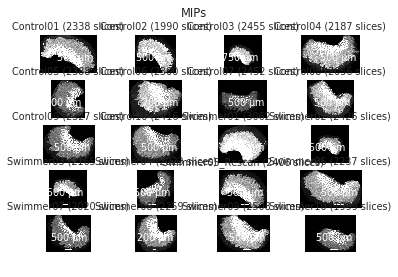

In [89]:
# Display calculated MIPs
for c, m in enumerate(MIPs):
    plt.subplot(lines, numpy.ceil(len(SampleNames) / float(lines)), c + 1)
    plt.imshow(m)
    plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
    plt.title('%s (%s slices)' % (SampleNames[c], len(Data.SubsetNames[c])))
    plt.axis('off')
plt.suptitle('MIPs')
# plt.savefig(os.path.join(OutPutDir, 'MIPs_from%04dslices.png' % NumberOfImagesToShow), bbox_inches='tight')
plt.show()

In [90]:
# grab the thresholds in the 60-80% range of the respective values
split = 5
Selected = [sorted(t)[(split - 2) * len(t) // split:(split - 1) * len(t) // split] for t in Data.Threshold]
# mask the values of the threshold that are *not* in this range
Otsu_selected = [numpy.ma.masked_outside(o, numpy.min(sel), numpy.max(sel)) for o, sel in zip(Data.Threshold, Selected)]
# use the mean of this 60-80% value to threshold the datasets
Data['Threshold6080'] = [numpy.nanmean(os) for os in Otsu_selected]

In [91]:
# # Display the different thresholds
# for c, s in enumerate(SampleNames):
#     plt.plot(Data.Threshold[c], marker='', label='%s | Global Otsu Mean=%.2f | 60-80%% Otsu mean=%0.2f' % (s,
#                                                                                                            Data.ThresholdAverage[c],
#                                                                                                            Data.Threshold6080[c]),
#              c=seaborn.color_palette(n_colors=len(SampleNames))[c])
#     plt.plot(Otsu_selected[c], '.', ms=5, alpha=0.618,
#              c=seaborn.color_palette(n_colors=len(Data))[c])
# #     plt.legend(loc='best')
# plt.xlim([0, Data.NumberOfVOISlices.max()])
# plt.title('Otsu thresholds for each slice of each sample')
# plt.savefig(os.path.join(OutPutDir, 'Thresholds-all.png'), bbox_inches='tight')
# plt.show()

In [92]:
# # Compare global Otsu threshold, 60%-80% selected threshold and threshold from MIPs
# for c, s in enumerate(SampleNames):
#     print('For %s we have a' % s)
#     print('\t- 60-80%% selected threshold of %0.2f' % Data.Threshold6080[c])
#     print('\t- global Otsu threshold of %0.2f' % Data.ThresholdAverage[c])

In [93]:
# Show all (global) histograms
if not True:
    # This takes a while, since we 'ravel' all images from the subsets and calculate their histogram...
    for c, s in enumerate(SampleNames):
        plt.subplot(lines, numpy.ceil(len(SampleNames) / float(lines)), c + 1)
        plt.hist(numpy.array(VOISubset[c]).ravel(),
                 bins=32,
                 log=True,
                 color=Data.Color[c],
                 label='%s | %s VOI slices' % (s, len(VOISubset[c])))
        if CalculateAllThresholds:
            plt.axvline(Data.Threshold6080[c],
                        label='Selected Threshold: %0.2f' % Data.Threshold6080[c],
                        c=seaborn.color_palette()[2])
            plt.axvline(GlobalOtsu[c], label='Mean Otsu Threshold: %0.2f' % GlobalOtsu[c],
                        c=seaborn.color_palette()[3])
        plt.axvline(Otsu_MIP[c], label='MIP Otsu Threshold: %0.2f' % Otsu_MIP[c],
                    c=seaborn.color_palette()[4])
        plt.legend()
        plt.xlim([0, 255])
    plt.savefig(os.path.join(OutPutDir, 'Histograms_Thresholds_from%04dslices.png' % NumberOfImagesToShow), bbox_inches='tight')
    plt.show()

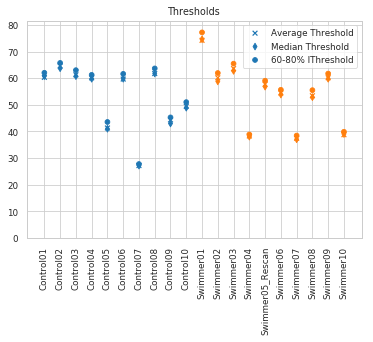

In [94]:
# Display the different thresholds
plt.scatter(x=Data.Sample, y=Data.ThresholdAverage, label='Average Threshold', c=Data.Color, marker='x')
plt.scatter(x=Data.Sample, y=Data.ThresholdMedian, label='Median Threshold', c=Data.Color, marker='d')
plt.scatter(x=Data.Sample, y=Data.Threshold6080, label='60-80% lThreshold', c=Data.Color)
plt.legend()
plt.ylim([0, Data.ThresholdAverage.max() * 1.1])
plt.xticks(rotation=90)
plt.title('Thresholds')
plt.show()

In [95]:
# # Show middle images with some data
# plt.rcParams['figure.figsize'] = (16, 5)
# for c, s in enumerate(SampleNames):
#     maximum = skimage.filters.rank.maximum(Data.MiddleSlice[c].astype('uint8'), skimage.morphology.disk(25))
#     plt.subplot(141)
#     plt.imshow(Data.MiddleSlice[c])
#     plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
#     plt.title('Middle slice of %s' % s)
#     plt.axis('off')
#     plt.subplot(142)
#     plt.imshow(Data.MiddleSlice[c], vmax=0.618 * numpy.max(Data.MiddleSlice[c]))
#     plt.imshow(maximum, cmap='viridis', alpha=0.5)
#     plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
#     plt.title('%s\nwith local maxima' % os.path.basename(Data.MiddleSliceName[c]))
#     plt.axis('off')
#     plt.subplot(143)
#     plt.hist(Data.MiddleSlice[c].ravel(), bins=32, log=True, color=Data.Color[c])
#     plt.axvline(Data.Threshold6080[c],
#                 label='60-80%% Threshold: %0.2f' % Data.Threshold6080[c],
#                 c=seaborn.color_palette()[2])
#     plt.axvline(Data.ThresholdAverage[c], label='Threshold Average: %0.2f' % Data.ThresholdAverage[c],
#                 c=seaborn.color_palette()[3])
#     plt.legend(loc='best')
#     plt.xlim([0, 255])
#     plt.title('Histogram of middle slice')
#     plt.subplot(144)
#     plt.imshow(MIPs[c])
#     plt.title('MIP of %s slices of %s' % (len(Data.SubsetNames[c]),
#                                           Data.Sample[c]))
#     plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
#     plt.axis('off')
#     plt.savefig(os.path.join(OutPutDir, 'Details_%s.png' % Data.Sample[c]), bbox_inches='tight')
#     plt.show()
# plt.rcParams['figure.figsize'] = (16, 9)

In [96]:
def calculate_area_gills(image):
    """
    This function calculates the gill area on an image.
    It is simply summing up all the thresholded pixels.
    I know we would not need a function for this, but let's try to keep the code clean :)
    """
    area_gills = numpy.sum(image)
    return(area_gills)

In [97]:
# Calculate the gill area (pythonic way, but without saving it in the middle...)
# Data['AreaGills'] = [[calculate_area_gills(i, threshold=t)
#                       for i, t in zip(subset, thrs)]
#                      for subset, thrs in zip(VOISubset, Data.Threshold)]

In [98]:
# Calculate the gill area (slow way, but with saving it in the middle...)
Data['OutputNameAreaGills'] = [os.path.join(f,
                                            '%s_area_gills_from_%04d_of_%04d_slices.npy' % (os.path.splitext(os.path.basename(thresholdmethod))[0],
                                                                                            len(n[::p]),
                                                                                            len(n)))
                               for f, n, p, thresholdmethod in zip(Data.Folder,
                                                                   Data.VOINames,
                                                                   Data.PrintEverySlice,
                                                                   Data.OutputNameThresholded)]
# Don't save results the dataframe, or else we won't be able to make it :)
Data['AreaGills'] = [numpy.nan for file in Data.OutputNameAreaGills]
for c, subset in enumerate(Thresholded):
    # Only do this if we didn't do it already...
    if os.path.exists(Data.OutputNameAreaGills[c]):
        print('%2s/%s: %16s: Already saved to %s' % (c + 1,
                                                     len(Data.Sample),
                                                     Data.Sample[c],
                                                     Data.OutputNameAreaGills[c][len(RootFolder):]))
    else:
        print('%2s/%s: %16s: Calculating gill area on %s of %s VOI images' % (c + 1,
                                                                              len(Data.Sample),
                                                                              Data.Sample[c],
                                                                              len(Data.SubsetNames[c]),
                                                                              len(Data.VOINames[c])))
        Data.AreaGills[c] = [None] * len(subset)
        for d, image in tqdm_notebook(enumerate(subset),
                                      total=len(subset),
                                      leave=False):
            Data.AreaGills[c][d] = calculate_area_gills(image)
        print('%23s: Saving area to %s' % (Data.Sample[c], Data.OutputNameAreaGills[c][len(RootFolder):]))
        numpy.save(Data.OutputNameAreaGills[c], Data.AreaGills[c], allow_pickle=False)
        Data.AreaGills[c] = numpy.nan
        # Free up memory
        subset._mmap.close()
        gc.collect()

 1/20:        Control01: Already saved to /Control01/Control01_gills_thresholded-slicewise_area_gills_from_2338_of_2338_slices.npy
 2/20:        Control02: Already saved to /Control02/Control02_gills_thresholded-slicewise_area_gills_from_1990_of_1990_slices.npy
 3/20:        Control03: Already saved to /Control03/Control03_gills_thresholded-slicewise_area_gills_from_2455_of_2455_slices.npy
 4/20:        Control04: Already saved to /Control04/Control04_gills_thresholded-slicewise_area_gills_from_2187_of_2187_slices.npy
 5/20:        Control05: Already saved to /Control05/Control05_gills_thresholded-slicewise_area_gills_from_2388_of_2388_slices.npy
 6/20:        Control06: Already saved to /Control06/Control06_gills_thresholded-slicewise_area_gills_from_2300_of_2300_slices.npy
 7/20:        Control07: Already saved to /Control07/Control07_gills_thresholded-slicewise_area_gills_from_2452_of_2452_slices.npy
 8/20:        Control08: Already saved to /Control08/Control08_gills_thresholded-sl

In [99]:
# Load (or memory-map) all the files again, since we closed them above.
Thresholded = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameThresholded]

In [100]:
def calculate_area_organ(image, threshold=None, verbose=False):
    """
    This function tries to estimate an organ area, e.g. the total organ area,
    by discarding (e.g filling/closing) the small voids between the secondary filament.
    """
    if numpy.min(image) == False:
        thresholded_image = image
        if verbose:
            print('Input image is already thresholded')
    else:
        if not threshold:
            # Calculate the Otsu threshold of the image if needed
            try:
                threshold = skimage.filters.threshold_otsu(image)
                if verbose:
                    print('Thresholding imput image with %0.2f' % threshold)
                thresholded_image = image > threshold
            except (ValueError):
                thresholded_image = numpy.zeros_like(image)
    # Use simple binary closing with a large kernel to fill out all the voids
    closed = skimage.morphology.binary_closing(thresholded_image,
                                               selem=skimage.morphology.selem.disk(11))
    if verbose:
        # mask out Deas ROI
        masked = numpy.ma.masked_equal(image, 0)
        # Show the images
        plt.subplot(131)
        plt.imshow(masked.filled(0))
        plt.axis('off')
        plt.title('Original')
        plt.subplot(132)
        plt.imshow(thresholded_image)
        plt.axis('off')
        if numpy.min(image) is False:
            plt.title('Input image *is* already thresholded')
        else:
            plt.title('Thresholded with %0.2f: %0.2g px' % (threshold,
                                                            numpy.sum(thresholded_image)))
        plt.subplot(133)
        plt.imshow(closed)
        plt.axis('off')
        plt.title('Closed: %0.2g px' % numpy.sum(closed))
        plt.show()
    area_organ = numpy.sum(closed)
    return(area_organ, closed)

In [101]:
# Calculate the (extrapolated) organ area (pythonic way, but without saving it in the middle...)
# Data['AreaOrgan'] = [[calculate_area_organ(i, threshold=t)
#                       for i, t in zip(subset, thrs)]
#                      for subset, thrs in zip(VOISubset, Data.Threshold)]

In [102]:
# Calculate the (extrapolated) organ area (slow way, but with saving it in the middle...)
Data['OutputNameAreaOrgan'] = [os.path.join(f,
                                            '%s_area_organ_from_%04d_of_%04d_slices.npy' % (os.path.splitext(os.path.basename(thresholdmethod))[0],
                                                                                            len(n[::p]),
                                                                                            len(n)))
                               for f, n, p, thresholdmethod in zip(Data.Folder,
                                                                   Data.VOINames,
                                                                   Data.PrintEverySlice,
                                                                   Data.OutputNameThresholded)]
Data['OutputNameOrgan'] = [os.path.join(f,
                                        '%s_organ_from_%04d_of_%04d_slices.npy' % (os.path.splitext(os.path.basename(thresholdmethod))[0],
                                                                                   len(n[::p]),
                                                                                   len(n)))
                           for f, n, p, thresholdmethod in zip(Data.Folder,
                                                               Data.VOINames,
                                                               Data.PrintEverySlice,
                                                               Data.OutputNameThresholded)]
# Don't save the resulting images into the dataframe, or else we won't be able to make it :)
Data['AreaOrgan'] = [numpy.nan for file in Data.OutputNameAreaOrgan]
Closed = [numpy.nan for file in Data.OutputNameAreaOrgan]
for c, subset in enumerate(Thresholded):
    # Only do this if we didn't do it already...
    if os.path.exists(Data.OutputNameAreaOrgan[c]) and os.path.exists(Data.OutputNameOrgan[c]):
        print('%2s/%s: %16s: Already saved to %s' % (c + 1,
                                                     len(Data.Sample),
                                                     Data.Sample[c],
                                                     Data.OutputNameAreaOrgan[c][len(RootFolder):]))
    else:
        print('%2s/%s: %16s: Calculating organ area on %s of %s VOI images' % (c + 1,
                                                                               len(Data.Sample),
                                                                               Data.Sample[c],
                                                                               len(Data.SubsetNames[c]),
                                                                               len(Data.VOINames[c])))
        Data.AreaOrgan[c] = [None] * len(subset)
        Closed[c] = [None] * len(subset)
        for d, image in tqdm_notebook(enumerate(subset),
                                      total=len(subset),
                                      leave=False):
            Data['AreaOrgan'][c][d], Closed[c][d] = calculate_area_organ(image)
        print('%s: Saving area to %s' % (os.path.basename(sample.Sample.rjust(namelenmax + 7)),
                                         Data.OutputNameAreaOrgan[c][len(RootFolder):]))
        numpy.save(Data.OutputNameAreaOrgan[c],
                   Data['AreaOrgan'][c],
                   allow_pickle=False)
        print('%s: Saving closed images to %s' % (Data.Sample[c].rjust(namelenmax + 7),
                                                  Data.OutputNameOrgan[c][len(RootFolder):]))
        numpy.save(Data['OutputNameOrgan'][c],
                   Closed[c],
                   allow_pickle=False)
        Data.AreaOrgan[c] = numpy.nan
        Closed[c] = numpy.nan
        # Free up memory
        subset._mmap.close()
        gc.collect()

 1/20:        Control01: Already saved to /Control01/Control01_gills_thresholded-slicewise_area_organ_from_2338_of_2338_slices.npy
 2/20:        Control02: Already saved to /Control02/Control02_gills_thresholded-slicewise_area_organ_from_1990_of_1990_slices.npy
 3/20:        Control03: Already saved to /Control03/Control03_gills_thresholded-slicewise_area_organ_from_2455_of_2455_slices.npy
 4/20:        Control04: Already saved to /Control04/Control04_gills_thresholded-slicewise_area_organ_from_2187_of_2187_slices.npy
 5/20:        Control05: Already saved to /Control05/Control05_gills_thresholded-slicewise_area_organ_from_2388_of_2388_slices.npy
 6/20:        Control06: Already saved to /Control06/Control06_gills_thresholded-slicewise_area_organ_from_2300_of_2300_slices.npy
 7/20:        Control07: Already saved to /Control07/Control07_gills_thresholded-slicewise_area_organ_from_2452_of_2452_slices.npy
 8/20:        Control08: Already saved to /Control08/Control08_gills_thresholded-sl

In [103]:
# Load (or memory-map) all the files again, since we closed them above.
if Data.PrintEverySlice[0] == 1:
    # If we did NOT use a subset, load the original stack...
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]
else:
    # If we did use a subset, then load the subset
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOISubset]

In [104]:
# Load (or memory-map) all the files again, since we closed them above.
Closed = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameOrgan]

In [105]:
# Save organ area images out
for c, sample in Data.iterrows():
    sample['CurrentOutputFolder'] = os.path.splitext(Data.OutputNameThresholded[c])[0].replace(Data.Sample[c] + '_gills', 'VOI_organ_area')
    if not os.path.exists(sample.CurrentOutputFolder):
        os.makedirs(sample.CurrentOutputFolder)
    if len(glob.glob(os.path.join(sample.CurrentOutputFolder, '*.png'))) >= sample.NumberOfAnalyzedVOISlices:
        print('%2s/%s: %7s: Already saved %3s organ area images to %s' % (c + 1,
                                                                          len(Data),
                                                                          sample.Sample,
                                                                          sample.NumberOfAnalyzedVOISlices,
                                                                          sample.CurrentOutputFolder[len(RootFolder):]))
    else:
        print('%2s/%s: %7s: Saving %3s organ area images to %s' % (c + 1,
                                                                   len(Data),
                                                                   Data.Sample[c],
                                                                   sample.NumberOfAnalyzedVOISlices,
                                                                   sample['CurrentOutputFolder'][len(RootFolder):]))
        for d, i in tqdm_notebook(enumerate(Closed[c]),
                                  total=len(Closed[c]),
                                  leave=False):
            scipy.misc.imsave(os.path.join(sample.CurrentOutputFolder,
                                           sample.Sample + '_area_organ_%04d.png' % d),
                              i.astype('uint8') * 255)

 1/20: Control01: Already saved 2338 organ area images to /Control01/VOI_organ_area_thresholded-slicewise
 2/20: Control02: Already saved 1990 organ area images to /Control02/VOI_organ_area_thresholded-slicewise
 3/20: Control03: Already saved 2455 organ area images to /Control03/VOI_organ_area_thresholded-slicewise
 4/20: Control04: Already saved 2187 organ area images to /Control04/VOI_organ_area_thresholded-slicewise
 5/20: Control05: Already saved 2388 organ area images to /Control05/VOI_organ_area_thresholded-slicewise
 6/20: Control06: Already saved 2300 organ area images to /Control06/VOI_organ_area_thresholded-slicewise
 7/20: Control07: Already saved 2452 organ area images to /Control07/VOI_organ_area_thresholded-slicewise
 8/20: Control08: Already saved 2056 organ area images to /Control08/VOI_organ_area_thresholded-slicewise
 9/20: Control09: Already saved 2327 organ area images to /Control09/VOI_organ_area_thresholded-slicewise
10/20: Control10: Already saved 2416 organ are

In [106]:
# Load the data in
Data['AreaGills'] = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameAreaGills]
Data['AreaOrgan'] = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameAreaOrgan]

In [107]:
# for c, row in Data.iterrows():
#     print(80*'-')
#     print(row.Sample)
#     print(row.AreaGills)
#     print(row.AreaOrgan)
#     print(row.AreaGills / row.AreaOrgan)

In [108]:
# Sum the images to get the volume of the gills and organ
# This volume is obviously in voxels
Data['VolumeGills'] = [numpy.sum(ag) for ag in Data.AreaGills]
Data['VolumeOrgan'] = [numpy.sum(ao) for ao in Data.AreaOrgan]

In [109]:
# Calculate the volume in microliters (or mm^3)
Data['VolumeGills_ul'] = [vg * vv for vg, vv in zip(Data.VolumeGills, Data.VoxelVolume)]
Data['VolumeOrgan_ul'] = [vo * vv for vo, vv in zip(Data.VolumeOrgan, Data.VoxelVolume)]

In [110]:
# Calculate the gills per organ ratio
Data['GillsPerOrgan'] = [ag / ao for (ag, ao) in zip(Data['AreaGills'], Data['AreaOrgan'])]

In [111]:
# # Display data
# for c, row in Data.iterrows():
#     plt.subplot(121)
#     plt.plot(row.AreaGills)
#     plt.plot(row.AreaOrgan)
#     plt.subplot(122)
#     plt.plot(row.GillsPerOrgan)
#     plt.title(row.Sample)
#     plt.show()

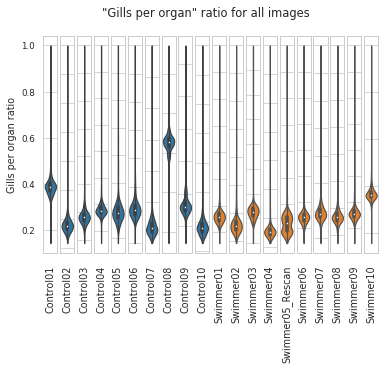

In [112]:
# Plot the Areas
for c, a in enumerate(Data.GillsPerOrgan):
    plt.subplot(1, len(Data), c + 1)
    seaborn.violinplot(a, orient='v', color=Data.Color[c], cut=0)
    if c:
        plt.gca().axes.yaxis.set_ticklabels([])
    else:
        plt.ylabel('Gills per organ ratio')
    plt.xlabel(Data.Sample[c], rotation=90)
plt.suptitle('"Gills per organ" ratio for all images')
plt.savefig(os.path.join(OutPutDir,
                         'Gills_per_organ_from%04dslices.png' % NumberOfImagesToShow),
            bbox_inches='tight')
plt.show()

In [113]:
# Calculate the mean 'gills per organ' ratio
Data['Mean_Gill_Ratio'] = [float(numpy.nanmean(a)) for a in Data['GillsPerOrgan']]

In [114]:
# Calculate the gill volume normalized to the fish length
Data['VolumeGillsNormalized'] = [numpy.divide(gv, w) for gv, w in zip(Data.VolumeGills_ul, Data.Length)]

----

Now that we have all the data let's display all that we need!
The plots below are the ones that are shown in the manuscript.

In [115]:
# Change color palette from the default
# seaborn.set_palette(seaborn.color_palette('muted', 2))
# seaborn.set_palette(seaborn.color_palette('viridis', 2))
# seaborn.set_palette(seaborn.color_palette('hls', 2))
# seaborn.set_palette(seaborn.color_palette('Spectral', 2))
# seaborn.set_palette(seaborn.color_palette('PiYG', 2))
# seaborn.set_palette(seaborn.color_palette('cubehelix', 2))

----
# Swimming activity

In [116]:
# What do we have?
for training in Speed.Training.unique():
    for exp in Speed.Experiment.unique():
        for gender in Speed.Gender.unique():
            print('%s\t%s\t%s\tmean speed of %s fishes: %0.2f' % (exp,
                                                                  training,
                                                                  gender,
                                                                  len(Speed[(Speed['Experiment'] == exp) &
                                                                            (Speed['Training'] == training) &
                                                                            (Speed['Gender'] == gender)]['WaterSpeed'].dropna()),
                                                                 Speed[(Speed['Experiment'] == exp) &
                                                                       (Speed['Training'] == training) &
                                                                       (Speed['Gender'] == gender)]['WaterSpeed'].dropna().mean()))

Control	Before	Female	mean speed of 10 fishes: 30.50
Control	Before	Male	mean speed of 10 fishes: 38.00
Swimmer	Before	Female	mean speed of 10 fishes: 28.50
Swimmer	Before	Male	mean speed of 10 fishes: 38.00
Control	3 wk	Female	mean speed of 0 fishes: nan
Control	3 wk	Male	mean speed of 0 fishes: nan
Swimmer	3 wk	Female	mean speed of 10 fishes: 35.50
Swimmer	3 wk	Male	mean speed of 9 fishes: 48.33
Control	5 wk	Female	mean speed of 10 fishes: 32.50
Control	5 wk	Male	mean speed of 10 fishes: 39.50
Swimmer	5 wk	Female	mean speed of 10 fishes: 40.50
Swimmer	5 wk	Male	mean speed of 9 fishes: 47.78


In [117]:
# What do we have?
for training in Speed.Training.unique():
    for exp in Speed.Experiment.unique():
            print('%s\t%s\tmean speed of %s fishes: %0.1f' % (exp,
                                                              training,
                                                              len(Speed[(Speed['Experiment'] == exp) &
                                                                        (Speed['Training'] == training)]['WaterSpeed'].dropna()),
                                                              Speed[(Speed['Experiment'] == exp) &
                                                                    (Speed['Training'] == training)]['WaterSpeed'].dropna().mean()))

Control	Before	mean speed of 20 fishes: 34.2
Swimmer	Before	mean speed of 20 fishes: 33.2
Control	3 wk	mean speed of 0 fishes: nan
Swimmer	3 wk	mean speed of 19 fishes: 41.6
Control	5 wk	mean speed of 20 fishes: 36.0
Swimmer	5 wk	mean speed of 19 fishes: 43.9


In [118]:
p_values_training = pandas.concat([pandas.DataFrame(index=Speed.Training.unique(),
                                                    columns=Speed.Experiment.unique()),
                                   pandas.DataFrame(index=itertools.combinations(Speed.Training.unique(), 2),
                                                    columns=Speed.Experiment.unique())])
p_values_training['Control vs. Swimmer'] = numpy.nan

In [119]:
# Are there differences between control and swimmers?
for training in Speed.Training.unique():
    print(80 * '-')
    t_statistic, p_value = scipy.stats.ttest_ind(Speed[(Speed.Training == training)
                                                       & (Speed.Experiment == 'Control')].WaterSpeed.dropna(),
                                                 Speed[(Speed.Training == training)
                                                       & (Speed.Experiment == 'Swimmer')].WaterSpeed.dropna(),
                                                 equal_var=True)
    # Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
    p_values_training['Control vs. Swimmer'][training] = p_value / 2
    print("At %s, the duration for 'Control' and 'Swimmer' has an" % training)
    print('F value of %0.4s and a p value of %.2g (%s).' % (t_statistic,
                                                            p_values_training['Control vs. Swimmer'][training],
                                                            significance(p_values_training['Control vs. Swimmer'][training])))

--------------------------------------------------------------------------------
At Before, the duration for 'Control' and 'Swimmer' has an
F value of 0.58 and a p value of 0.28 (n.s.).
--------------------------------------------------------------------------------
At 3 wk, the duration for 'Control' and 'Swimmer' has an
F value of nan and a p value of nan (n.s.).
--------------------------------------------------------------------------------
At 5 wk, the duration for 'Control' and 'Swimmer' has an
F value of -5.3 and a p value of 2.7e-06 (***).


In [120]:
# Are the durations between trainings different?
for experiment in Speed.Experiment.unique():
    for trainings in itertools.combinations(Speed.Training.unique(), 2):
        print(80 * '-')
        t_statistic, p_value = scipy.stats.ttest_ind(Speed[(Speed.Training == trainings[0])
                                                           & (Speed.Experiment == experiment)].WaterSpeed.dropna(),
                                                     Speed[(Speed.Training == trainings[1])
                                                           & (Speed.Experiment == experiment)].WaterSpeed.dropna(),
                                                     equal_var=True)
        # Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
        p_values_training[experiment][trainings] = p_value / 2
        print("For the %s group, the data between '%s' and '%s' has an" % (experiment,
                                                                           trainings[0],
                                                                           trainings[1]))
        print('F value of %0.4s and a p value of %.2g (%s).' % (t_statistic,
                                                                p_values_training[experiment][trainings],
                                                                significance(p_values_training[experiment][trainings])))

--------------------------------------------------------------------------------
For the Control group, the data between 'Before' and '3 wk' has an
F value of nan and a p value of nan (n.s.).
--------------------------------------------------------------------------------
For the Control group, the data between 'Before' and '5 wk' has an
F value of -1.1 and a p value of 0.14 (n.s.).
--------------------------------------------------------------------------------
For the Control group, the data between '3 wk' and '5 wk' has an
F value of nan and a p value of nan (n.s.).
--------------------------------------------------------------------------------
For the Swimmer group, the data between 'Before' and '3 wk' has an
F value of -3.7 and a p value of 0.00029 (***).
--------------------------------------------------------------------------------
For the Swimmer group, the data between 'Before' and '5 wk' has an
F value of -6.4 and a p value of 7.8e-08 (***).
--------------------------------

In [121]:
# Are the durations between trainings different?
for experiment in Speed.Experiment.unique():
    for trainings in itertools.combinations(Speed.Training.unique(), 2):
        print(80 * '-')
        t_statistic, p_value = scipy.stats.ttest_ind(Speed[(Speed.Training == trainings[0])
                                                           & (Speed.Experiment == experiment)].WaterSpeed.dropna(),
                                                     Speed[(Speed.Training == trainings[1])
                                                           & (Speed.Experiment == experiment)].WaterSpeed.dropna(),
                                                     equal_var=True)
        # Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
        p_values_training[experiment][trainings] = p_value / 2
        print("For the %s group, the data between '%s' and '%s' has an" % (experiment,
                                                                           trainings[0],
                                                                           trainings[1]))
        print('F value of %0.4s and a p value of %.2g. (%s)' % (t_statistic,
                                                                p_values_training[experiment][trainings],
                                                                significance(p_values_training[experiment][trainings])))

--------------------------------------------------------------------------------
For the Control group, the data between 'Before' and '3 wk' has an
F value of nan and a p value of nan. (n.s.)
--------------------------------------------------------------------------------
For the Control group, the data between 'Before' and '5 wk' has an
F value of -1.1 and a p value of 0.14. (n.s.)
--------------------------------------------------------------------------------
For the Control group, the data between '3 wk' and '5 wk' has an
F value of nan and a p value of nan. (n.s.)
--------------------------------------------------------------------------------
For the Swimmer group, the data between 'Before' and '3 wk' has an
F value of -3.7 and a p value of 0.00029. (***)
--------------------------------------------------------------------------------
For the Swimmer group, the data between 'Before' and '5 wk' has an
F value of -6.4 and a p value of 7.8e-08. (***)
--------------------------------

In [122]:
p_values_training

,Control,Swimmer,Control vs. Swimmer
Before,NaN,NaN,0.282488
3 wk,NaN,NaN,NaN
5 wk,NaN,NaN,0.000003
"(Before, 3 wk)",NaN,0.000291131,NaN
"(Before, 5 wk)",0.13689,7.82334e-08,NaN
"(3 wk, 5 wk)",NaN,0.135236,NaN


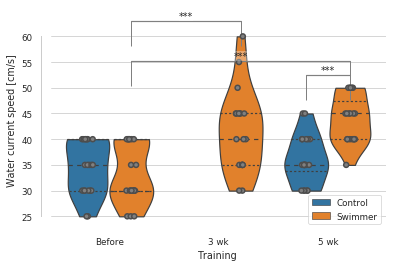

In [123]:
# Plot the speed data
import matplotlib.dates as mdates
seaborn.violinplot(data=Speed, hue='Experiment', y='WaterSpeed', x='Training', cut=0, inner='quartiles')
seaborn.stripplot(data=Speed, hue='Experiment', y='WaterSpeed', x='Training',
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  palette=['gray', 'gray'])
legend = True
if legend:
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:len(handles) // 2],
               labels[:len(labels) // 2],
               loc='lower right')
else:
    plt.legend().set_visible(False)
plt.ylabel('Water current speed [cm/s]')    
significance_bar(0 + 0.2,
                 1 + 0.2,
                 numpy.maximum(Speed[(Speed.Experiment == 'Swimmer')
                                     & (Speed.Training == 'Before')].WaterSpeed.max(),
                               Speed[(Speed.Experiment == 'Swimmer')
                                     & (Speed.Training == '3 wk')].WaterSpeed.max()),
                 p_values_training['Swimmer'][-3])
significance_bar(2 - 0.2,
                 2 + 0.2,
                 Speed[(Speed.Training == '5 wk')].WaterSpeed.max(),
                 p_values_training['Control vs. Swimmer']['5 wk'])
significance_bar(0 + 0.2,
                 2 + 0.2,
                 1.05 * numpy.maximum(Speed[(Speed.Experiment == 'Swimmer')
                                            & (Speed.Training == 'Before')].WaterSpeed.max(),
                                      Speed[(Speed.Experiment == 'Swimmer')
                                            & (Speed.Training == '5 wk')].WaterSpeed.max()),
                 p_values_training['Swimmer'][-2])
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir,
                         'Endurance.png'),
            bbox_inches='tight')
plt.show()

In [124]:
# Data as prose
for experiment in Speed.Experiment.unique():
    print(80 * '-')
    for training in Speed.Training.unique():
        print('The endurance of the %s group at %s training was %s min %s sec '
              'with a STD of %s min %s sec.' % (experiment,
                                                training,
                                                pandas.to_datetime(Speed[(Speed.Experiment == experiment)
                                                                         & (Speed.Training == training)].Seconds.mean(),
                                                                   unit='s').minute,
                                                pandas.to_datetime(Speed[(Speed.Experiment == experiment)
                                                                         & (Speed.Training == training)].Seconds.mean(),
                                                                   unit='s').second,
                                                pandas.to_datetime(Speed[(Speed.Experiment == experiment)
                                                                         & (Speed.Training == training)].Seconds.std(),
                                                                   unit='s').minute,
                                                pandas.to_datetime(Speed[(Speed.Experiment == experiment)
                                                                         & (Speed.Training == training)].Seconds.std(),
                                                                   unit='s').second))

--------------------------------------------------------------------------------
The endurance of the Control group at Before training was 12 min 38 sec with a STD of 1 min 48 sec.
The endurance of the Control group at 3 wk training was nan min nan sec with a STD of nan min nan sec.
The endurance of the Control group at 5 wk training was 13 min 30 sec with a STD of 1 min 46 sec.
--------------------------------------------------------------------------------
The endurance of the Swimmer group at Before training was 12 min 9 sec with a STD of 2 min 5 sec.
The endurance of the Swimmer group at 3 wk training was 15 min 26 sec with a STD of 3 min 10 sec.
The endurance of the Swimmer group at 5 wk training was 16 min 29 sec with a STD of 1 min 54 sec.


In [125]:
# Data as prose
for training in Speed.Training.unique():
    print('The endurance of the fishes at %s training was %s min %s sec '
          'with a STD of %s min %s sec.' % (training,
                                            pandas.to_datetime(Speed[(Speed.Training == training)].Seconds.mean(),
                                                               unit='s').minute,
                                            pandas.to_datetime(Speed[(Speed.Training == training)].Seconds.mean(),
                                                               unit='s').second,
                                            pandas.to_datetime(Speed[(Speed.Training == training)].Seconds.std(),
                                                               unit='s').minute,
                                            pandas.to_datetime(Speed[(Speed.Training == training)].Seconds.std(),
                                                               unit='s').second))

The endurance of the fishes at Before training was 12 min 24 sec with a STD of 1 min 56 sec.
The endurance of the fishes at 3 wk training was 15 min 26 sec with a STD of 3 min 10 sec.
The endurance of the fishes at 5 wk training was 14 min 58 sec with a STD of 2 min 21 sec.


In [126]:
for experiment in Speed.Experiment.unique():
    print(80 * '-')
    for trainings in itertools.combinations(Speed.Training.unique(), 2):
        print('The speed of the %s '
              'increased by %0.1f %% between '
              '"%s" and "%s"' % (experiment,
                                 percentage(Speed[(Speed.Experiment == experiment)
                                                  & (Speed.Training == trainings[0])].Seconds.mean(),
                                            Speed[(Speed.Experiment == experiment)
                                                  & (Speed.Training == trainings[1])].Seconds.mean()),
                                 trainings[0],
                                 trainings[1]))

--------------------------------------------------------------------------------
The speed of the Control increased by nan % between "Before" and "3 wk"
The speed of the Control increased by 6.9 % between "Before" and "5 wk"
The speed of the Control increased by nan % between "3 wk" and "5 wk"
--------------------------------------------------------------------------------
The speed of the Swimmer increased by 27.0 % between "Before" and "3 wk"
The speed of the Swimmer increased by 35.6 % between "Before" and "5 wk"
The speed of the Swimmer increased by 6.8 % between "3 wk" and "5 wk"


----
# Morphology

## Length

In [127]:
# What do we have?
for training in Morphology.Training.unique():
    for exp in Morphology.Experiment.unique():
            print('%s\t%s\tmean length of %s fishes: %0.2f' % (exp,
                                                               training,
                                                               len(Morphology[(Morphology['Experiment'] == exp) &
                                                                              (Morphology['Training'] == training)]['Length'].dropna()),
                                                               Morphology[(Morphology['Experiment'] == exp) &
                                                                          (Morphology['Training'] == training)]['Length'].dropna().mean()))

Control	Before	mean length of 20 fishes: 29.40
Swimmer	Before	mean length of 20 fishes: 29.07
Control	After	mean length of 20 fishes: 29.60
Swimmer	After	mean length of 19 fishes: 30.45


In [128]:
p_values_length = [None] * 4

In [129]:
# Are there length differences between control and swimmers?
for c, training in enumerate(Morphology.Training.unique()):
    print(80 * '-')
    t_statistic, p_values_length[c] = scipy.stats.ttest_ind(Morphology[(Morphology.Training == training)
                                                                       & (Morphology.Experiment == 'Control')].Length.dropna(),
                                                            Morphology[(Morphology.Training == training)
                                                                       & (Morphology.Experiment == 'Swimmer')].Length.dropna(),
                                                            equal_var=True)
    print("At %s, the 'lengths' for 'Control' and 'Swimmer' have a" % training)
    # Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
    p_values_length[c] /= 2
    print('F value of %0.4s and a p value of %.2g (%s).' % (t_statistic,
                                                            p_values_length[c],
                                                            significance(p_values_length[c])))

--------------------------------------------------------------------------------
At Before, the 'lengths' for 'Control' and 'Swimmer' have a
F value of 0.53 and a p value of 0.3 (n.s.).
--------------------------------------------------------------------------------
At After, the 'lengths' for 'Control' and 'Swimmer' have a
F value of -1.5 and a p value of 0.061 (n.s.).


In [130]:
# Are the lengths between trainings different?
for c, experiment in enumerate(Morphology.Experiment.unique()):
    for trainings in itertools.combinations(Morphology.Training.unique(), 2):
        print(80 * '-')
        t_statistic, p_values_length[c + 2] = scipy.stats.ttest_ind(Morphology[(Morphology.Training == trainings[0])
                                                                               & (Morphology.Experiment == experiment)].Length.dropna(),
                                                                    Morphology[(Morphology.Training == trainings[1])
                                                                               & (Morphology.Experiment == experiment)].Length.dropna(),
                                                                    equal_var=True)
        print("For the %s group, the 'length' between '%s' and '%s' has an" % (experiment,
                                                                               trainings[0],
                                                                               trainings[1]))
        # Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
        p_values_length[c + 2] /= 2
        print('F value of %0.4s and a p value of %.2g. (%s)' % (t_statistic,
                                                                p_values_length[c + 2],
                                                                significance(p_values_length[c + 2])))

--------------------------------------------------------------------------------
For the Control group, the 'length' between 'Before' and 'After' has an
F value of -0.3 and a p value of 0.35. (n.s.)
--------------------------------------------------------------------------------
For the Swimmer group, the 'length' between 'Before' and 'After' has an
F value of -2.1 and a p value of 0.018. (*)


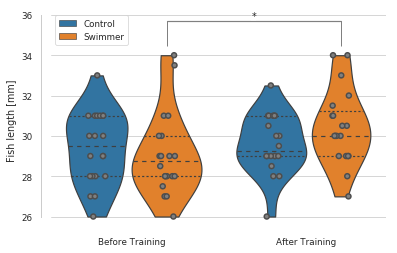

In [131]:
# Display fish length
seaborn.violinplot(data=Morphology, hue='Experiment', y='Length', x='Training', cut=0, inner='quartiles')
seaborn.stripplot(data=Morphology, hue='Experiment', y='Length', x='Training',
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  palette=['gray', 'gray'])
if legend:
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:len(handles) // 2],
               labels[:len(labels) // 2],
               loc='upper left')
else:
    plt.legend().set_visible(False)
plt.xlabel('')
plt.ylabel('Fish length [mm]')
plt.gca().set_xticklabels(['Before Training', 'After Training'])
significance_bar(0 + 0.2,
                 1 + 0.2,
                 Morphology[(Morphology.Experiment == 'Swimmer')].Length.max(),
                 p_values_length[-1])
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir,
                         'Lengths.png'),
            bbox_inches='tight')
plt.show()

In [132]:
# Data as prose
for experiment in Morphology.Experiment.unique():
    print(80 * '-')
    for training in Morphology.Training.unique():
        print('The body length of the %s group %s training '
              'was %0.1f mm with a STD of %0.1f.' % (experiment,
                                                     training,
                                                     Morphology[(Morphology.Experiment == experiment)
                                                                & (Morphology.Training == training)].Length.mean(),
                                                     Morphology[(Morphology.Experiment == experiment)
                                                                & (Morphology.Training == training)].Length.std()))

--------------------------------------------------------------------------------
The body length of the Control group Before training was 29.4 mm with a STD of 1.8.
The body length of the Control group After training was 29.6 mm with a STD of 1.5.
--------------------------------------------------------------------------------
The body length of the Swimmer group Before training was 29.1 mm with a STD of 2.0.
The body length of the Swimmer group After training was 30.4 mm with a STD of 1.9.


In [133]:
for experiment in Morphology.Experiment.unique():
    for trainings in itertools.combinations(Morphology.Training.unique(), 2):
        print('The body length of the %s '
              'increased by %0.1f %% between '
              '"%s" and "%s"' % (experiment,
                                 percentage(Morphology[(Morphology.Experiment == experiment)
                                                       & (Morphology.Training == trainings[0])].Length.mean(),
                                            Morphology[(Morphology.Experiment == experiment)
                                                       & (Morphology.Training == trainings[1])].Length.mean()),
                                 trainings[0],
                                 trainings[1]))

The body length of the Control increased by 0.7 % between "Before" and "After"
The body length of the Swimmer increased by 4.7 % between "Before" and "After"


## Weight

In [134]:
# What do we have?
for training in Morphology.Training.unique():
    for exp in Morphology.Experiment.unique():
            print('%s\t%s\t%s\tmean weight of %s fishes: %0.2f' % (exp,
                                                                   training,
                                                                   'male',
                                                                   len(Morphology[(Morphology['Experiment'] == exp) &
                                                                                  (Morphology['Training'] == training) &
                                                                                  (Morphology['Gender'] == 'Male')]['Weight'].dropna()),
                                                                   Morphology[(Morphology['Experiment'] == exp) &
                                                                              (Morphology['Training'] == training) &
                                                                              (Morphology['Gender'] == 'Male')]['Weight'].dropna().mean()))

Control	Before	male	mean weight of 10 fishes: 0.38
Swimmer	Before	male	mean weight of 10 fishes: 0.37
Control	After	male	mean weight of 10 fishes: 0.39
Swimmer	After	male	mean weight of 9 fishes: 0.44


In [135]:
p_values_weight = [None] * 4

In [136]:
# Are there weight differences between control and swimmers?
for c, training in enumerate(Morphology.Training.unique()):
    print(80 * '-')
    t_statistic, p_values_weight[c] = scipy.stats.ttest_ind(Morphology[(Morphology.Gender == 'Male')
                                                                       & (Morphology.Training == training)
                                                                       & (Morphology.Experiment == 'Control')].Weight.dropna(),
                                                            Morphology[(Morphology.Gender == 'Male')
                                                                       & (Morphology.Training == training)
                                                                       & (Morphology.Experiment == 'Swimmer')].Weight.dropna(),
                                                            equal_var=True)
    print("At %s, the weight for 'Control' and 'Swimmer' has an" % training)
    # Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
    p_values_weight[c] /= 2
    print('F value of %0.4s and a p value of %.2g (%s).' % (t_statistic,
                                                            p_values_weight[c],
                                                            significance(p_values_weight[c])))

--------------------------------------------------------------------------------
At Before, the weight for 'Control' and 'Swimmer' has an
F value of 0.23 and a p value of 0.41 (n.s.).
--------------------------------------------------------------------------------
At After, the weight for 'Control' and 'Swimmer' has an
F value of -1.8 and a p value of 0.041 (*).


In [137]:
# Are the weights between trainings different?
for c, experiment in enumerate(Morphology.Experiment.unique()):
    for trainings in itertools.combinations(Morphology.Training.unique(), 2):
        print(80 * '-')
        t_statistic, p_values_weight[c + 2] = scipy.stats.ttest_ind(Morphology[(Morphology.Gender == 'Male')
                                                                               & (Morphology.Training == trainings[0])
                                                                               & (Morphology.Experiment == experiment)].Weight.dropna(),
                                                                    Morphology[(Morphology.Gender == 'Male')
                                                                               & (Morphology.Training == trainings[1])
                                                                               & (Morphology.Experiment == experiment)].Weight.dropna(),
                                                                    equal_var=True)
        print("For the %s group, the weight between '%s' and '%s' has an" % (experiment,
                                                                             trainings[0],
                                                                             trainings[1]))
        # Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
        p_values_weight[c + 2] /= 2
        print('F value of %0.4s and a p value of %.2g. (%s)' % (t_statistic,
                                                                p_values_weight[c + 2],
                                                                significance(p_values_weight[c + 2])))

--------------------------------------------------------------------------------
For the Control group, the weight between 'Before' and 'After' has an
F value of -0.7 and a p value of 0.24. (n.s.)
--------------------------------------------------------------------------------
For the Swimmer group, the weight between 'Before' and 'After' has an
F value of -2.5 and a p value of 0.011. (*)


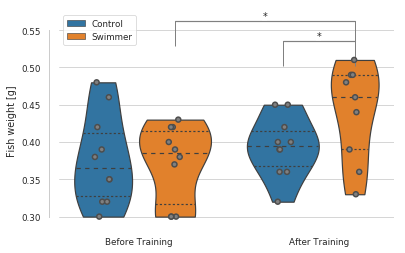

In [138]:
# Display male fish weight
seaborn.violinplot(data=Morphology[Morphology.Gender == 'Male'], hue='Experiment', y='Weight', x='Training',
                   cut=0, inner='quartiles')
seaborn.stripplot(data=Morphology[Morphology.Gender == 'Male'], hue='Experiment', y='Weight', x='Training',
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  palette=['gray', 'gray'])
if legend:
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:len(handles) // 2],
               labels[:len(labels) // 2],
               loc='upper left')
else:
    plt.legend().set_visible(False)
plt.xlabel('')
plt.gca().set_xticklabels(['Before Training', 'After Training'])
plt.ylabel('Fish weight [g]')
significance_bar(1 - 0.2,
                 1 + 0.2,
                 Morphology[(Morphology.Gender == 'Male')
                            & (Morphology.Training == 'After')].Weight.max(),
                 p_values_weight[1])
significance_bar(0 + 0.2,
                 1 + 0.2,
                 1.05 * Morphology[(Morphology.Gender == 'Male')
                                   & (Morphology.Experiment == 'Swimmer')].Weight.max(),
                 p_values_weight[-1])
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir,
                         'Weights.png'),
            bbox_inches='tight')
plt.show()

In [139]:
# Data as prose
for experiment in Morphology.Experiment.unique():
    print(80 * '-')
    for training in Morphology.Training.unique():
        print('The weight of the male %s group %s training '
              'was %0.2f g with a STD of %0.2f.' % (experiment,
                                                    training,
                                                    Morphology[(Morphology.Gender == 'Male')
                                                               & (Morphology.Experiment == experiment)
                                                               & (Morphology.Training == training)].Weight.mean(),
                                                    Morphology[(Morphology.Gender == 'Male')
                                                               & (Morphology.Experiment == experiment)
                                                               & (Morphology.Training == training)].Weight.std()))

--------------------------------------------------------------------------------
The weight of the male Control group Before training was 0.38 g with a STD of 0.06.
The weight of the male Control group After training was 0.39 g with a STD of 0.04.
--------------------------------------------------------------------------------
The weight of the male Swimmer group Before training was 0.37 g with a STD of 0.05.
The weight of the male Swimmer group After training was 0.44 g with a STD of 0.06.


In [140]:
for experiment in Morphology.Experiment.unique():
    for trainings in itertools.combinations(Morphology.Training.unique(), 2):
        print('The weight of the male %s '
              'increased by %0.1f %% between '
              '"%s" and "%s"' % (experiment,
                                 percentage(Morphology[(Morphology.Gender == 'Male')
                                                       & (Morphology.Experiment == experiment)
                                                       & (Morphology.Training == trainings[0])].Weight.mean(),
                                            Morphology[(Morphology.Gender == 'Male')
                                                       & (Morphology.Experiment == experiment)
                                                       & (Morphology.Training == trainings[1])].Weight.mean()),
                                 trainings[0],
                                 trainings[1]))

The weight of the male Control increased by 4.5 % between "Before" and "After"
The weight of the male Swimmer increased by 18.3 % between "Before" and "After"


In [141]:
zerotheplots=False

----
# Scanning electron microscopy data

In [142]:
# Are the filament lenghts between trainings different?
t_statistic, p_value_filament_length = scipy.stats.ttest_ind(Filaments['Control Length'].dropna(),
                                                             Filaments['Swimmer Length'].dropna(),
                                                             equal_var=True)
print("The filament length between 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
p_value_filament_length /= 2
print('F value of %0.4s and a p value of %.2g. (%s)' % (t_statistic,
                                                        p_value_filament_length,
                                                        significance(p_value_filament_length)))

The filament length between 'Control' and 'Swimmer' has an
F value of -3.3 and a p value of 0.00043. (***)


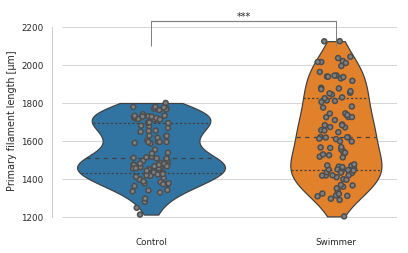

In [143]:
# Display filament length
seaborn.violinplot(data=Filaments[['Control Length', 'Swimmer Length']],
                   cut=0, inner='quartiles')
seaborn.stripplot(data=Filaments[['Control Length', 'Swimmer Length']],
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  color='gray')
significance_bar(0, 1,
                 numpy.max(Filaments[['Control Length', 'Swimmer Length']].max()),
                 p_value_filament_length)
plt.ylabel(u'Primary filament length [\u03bcm]')
plt.gca().set_xticklabels(['Control', 'Swimmer'])
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir,
                         'Filament_lenght.png'),
            bbox_inches='tight')
plt.show()

In [144]:
# Data as prose
print('The mean filament length for the control was %0.f um with a STD of %0.f.' % (Filaments['Control Length'].mean(),
                                                                                    Filaments['Control Length'].std()))
print('The mean filament length for the swimmers was %0.f um with a STD of %0.f.' % (Filaments['Swimmer Length'].mean(),
                                                                                     Filaments['Swimmer Length'].std()))

The mean filament length for the control was 1545 um with a STD of 148.
The mean filament length for the swimmers was 1639 um with a STD of 228.


In [145]:
print('This is an increase of %0.1f %%' % percentage(Filaments['Control Length'].mean(), Filaments['Swimmer Length'].mean()))

This is an increase of 6.1 %


In [146]:
# Are the filament counts between trainings different?
t_statistic, p_value_filament_count = scipy.stats.ttest_ind(Filaments['Control Count'].dropna(),
                                                            Filaments['Swimmer Count'].dropna(),
                                                            equal_var=True)
print("The filament count between 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
p_value_filament_count /= 2
print('F value of %0.4s and a p value of %.2g. (%s)' % (t_statistic,
                                                        p_value_filament_count,
                                                        significance(p_value_filament_count)))

The filament count between 'Control' and 'Swimmer' has an
F value of -5.8 and a p value of 9e-09. (***)


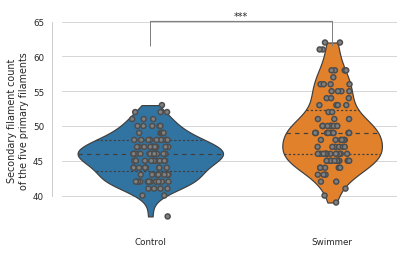

In [147]:
# Display filament count
seaborn.violinplot(data=Filaments[['Control Count', 'Swimmer Count']],
                   cut=0, inner='quartiles')
# seaborn.boxplot(data=Filaments[['Control Count', 'Swimmer Count']], notch=True)
seaborn.stripplot(data=Filaments[['Control Count', 'Swimmer Count']],
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  color='gray')
significance_bar(0,
                 1,
                 numpy.max(Filaments[['Control Count', 'Swimmer Count']].max()),
                 p_value_filament_count)
plt.ylabel('Secondary filament count\nof the five primary filaments')
plt.gca().set_xticklabels(['Control', 'Swimmer'])
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir,
                         'Filament_count.png'),
            bbox_inches='tight')
plt.show()

In [148]:
# Data as prose
print('The mean secondary filament count for the '
      'control group was %0.2f with a STD of %0.2f.' % (Filaments['Control Count'].mean(),
                                                        Filaments['Control Count'].std()))
print('The mean secondary filament count for the '
      'swimmers group was %0.2f with a STD of %0.2f.' % (Filaments['Swimmer Count'].mean(),
                                                         Filaments['Swimmer Count'].std()))

The mean secondary filament count for the control group was 45.73 with a STD of 3.13.
The mean secondary filament count for the swimmers group was 49.27 with a STD of 5.02.


In [149]:
print('This is an increase of %0.1f %%' % percentage(Filaments['Control Count'].mean(), Filaments['Swimmer Count'].mean()))

This is an increase of 7.7 %


In [150]:
Filaments.describe()

,Swimmer Count,Control Count,Swimmer Length,Control Length
count,100.000000,95.000000,100.000000,95.000000
mean,49.270000,45.726316,1638.623333,1545.031579
std,5.022887,3.126558,227.967819,147.799374
min,39.000000,37.000000,1202.000000,1211.666667
25%,46.000000,43.500000,1445.208333,1432.083333
50%,49.000000,46.000000,1617.500000,1509.666667
75%,52.250000,48.000000,1824.416667,1693.666667
max,62.000000,53.000000,2123.500000,1798.333333


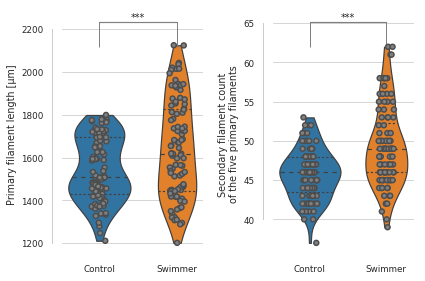

In [151]:
# Display both count and length in the same plot
plt.subplot(121)
seaborn.violinplot(data=Filaments[['Control Length', 'Swimmer Length']],
                   cut=0, inner='quartiles')
seaborn.stripplot(data=Filaments[['Control Length', 'Swimmer Length']],
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  color='gray')
significance_bar(0, 1,
                 numpy.max(Filaments[['Control Length', 'Swimmer Length']].max()),
                 p_value_filament_length)
plt.ylabel(u'Primary filament length [\u03bcm]')
plt.gca().set_xticklabels(['Control', 'Swimmer'])
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.subplot(122)
# Display filament count
seaborn.violinplot(data=Filaments[['Control Count', 'Swimmer Count']],
                   cut=0, inner='quartiles')
# seaborn.boxplot(data=Filaments[['Control Count', 'Swimmer Count']], notch=True)
seaborn.stripplot(data=Filaments[['Control Count', 'Swimmer Count']],
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  color='gray')
significance_bar(0,
                 1,
                 numpy.max(Filaments[['Control Count', 'Swimmer Count']].max()),
                 p_value_filament_count)
plt.ylabel('Secondary filament count\nof the five primary filaments')
plt.gca().set_xticklabels(['Control', 'Swimmer'])
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir,
                         'Filament_count.Filament_length.png'),
            bbox_inches='tight')
plt.show()

----
# Gill volume

In [152]:
# Shapiro -> Normalitätstest
scipy.stats.shapiro(Data.VolumeGills)
# nicht signifikant von Normalverteilung unterschiedlich

(0.9557097554206848, 0.46207961440086365)

In [153]:
# Levene -> Varianztest
scipy.stats.levene(Data.loc[Data.Experiment == 'Control'].VolumeGills,
                   Data.loc[Data.Experiment == 'Swimmer'].VolumeGills)
# nicht signifikant -> Wahrscheinlich nicht nicht normalverteilt

LeveneResult(statistic=0.43721179352661765, pvalue=0.5168463173822981)

In [154]:
# Compute the Kolmogorov-Smirnov statistic on 2 samples -> Verteilungen nicht unterschiedlich?
scipy.stats.ks_2samp(Data.loc[Data.Experiment == 'Control'].VolumeGills,
                     Data.loc[Data.Experiment == 'Swimmer'].VolumeGills)
# nicht signifikant -> wahrscheinlich nicht unterschiedliche Verteilung --> equal_var=True

Ks_2sampResult(statistic=0.5, pvalue=0.1108403374132281)

In [155]:
# Are the means different?
t_statistic, p_value_volume = scipy.stats.ttest_ind(Data.loc[Data.Experiment == 'Control'].VolumeGills,
                                                    Data.loc[Data.Experiment == 'Swimmer'].VolumeGills,
                                                    equal_var=True)
print("The difference between the 'gill volume' of 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
p_value_volume /= 2
print('F value of %0.4s and a p value of %.2g (%s).' % (t_statistic,
                                                        p_value_volume,
                                                        significance(p_value_volume)))

The difference between the 'gill volume' of 'Control' and 'Swimmer' has an
F value of -1.7 and a p value of 0.048 (*).


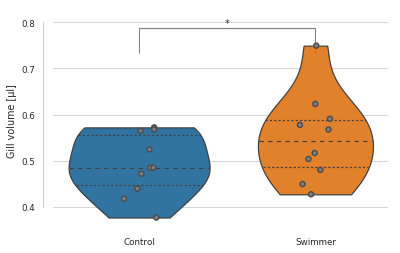

In [156]:
# Plot the gills volume for each animal (in ul)
bars = seaborn.violinplot(data=Data, x='Experiment', y='VolumeGills_ul', cut=0, inner='quartiles')
# bars = seaborn.boxplot(data=Data, x='Experiment', y='VolumeGills_ul')
seaborn.stripplot(data=Data, x='Experiment', y='VolumeGills_ul',
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  color='gray')
label = False
if label:
    shift = 0.05
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c],
                               (0 + shift * numpy.random.rand(),
                                Data.VolumeGills_ul[c]),
                               horizontalalignment='left', verticalalignment='bottom')
        else:
            plt.gca().annotate(Data.Sample[c],
                               (1 + shift * numpy.random.rand(),
                                Data.VolumeGills_ul[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.xlabel('')
plt.ylabel(u'Gill volume [\u03bcl]')  # https://stackoverflow.com/a/2140991/323100
plt.ylim(ymax=Data.VolumeGills_ul.max() * 1.1)
significance_bar(0, 1,
                 Data.VolumeGills_ul.max(),
                 p_value_volume)
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
if label:
    plt.savefig(os.path.join(OutPutDir,
                             'Volume_Gills_ul_from%04dslices.png' % NumberOfImagesToShow),
                bbox_inches='tight')
else:
    plt.savefig(os.path.join(OutPutDir,
                             'Volume_Gills_ul_from%04dslices_nolabel.png' % NumberOfImagesToShow),
                bbox_inches='tight')
plt.show()

In [157]:
# Data as prose
for experiment in Data.Experiment.unique():
    print('The %s fishes have a mean gill volume '
          'of %0.2f mm^3 with a STD of %0.2f' % (experiment,
                                                 Data[Data.Experiment == experiment]['VolumeGills_ul'].mean(),
                                                 Data[Data.Experiment == experiment]['VolumeGills_ul'].std()))
print('This is an increase of %0.1f %%' % percentage(Data['VolumeGills_ul'][Data.Experiment == 'Control'].mean(),
                                                     Data['VolumeGills_ul'][Data.Experiment == 'Swimmer'].mean()))

The Control fishes have a mean gill volume of 0.49 mm^3 with a STD of 0.07
The Swimmer fishes have a mean gill volume of 0.55 mm^3 with a STD of 0.09
This is an increase of 11.8 %


----
# Gill volume, normalized

In [158]:
# Shapiro -> Normalitätstest
scipy.stats.shapiro(Data.VolumeGillsNormalized)
# nicht signifikant von Normalverteilung unterschiedlich

(0.9585453867912292, 0.5152152180671692)

In [159]:
# Levene -> Varianztest
scipy.stats.levene(Data.loc[Data.Experiment == 'Control'].VolumeGillsNormalized,
                   Data.loc[Data.Experiment == 'Swimmer'].VolumeGillsNormalized)
# nicht signifikant -> Wahrscheinlich nicht nicht normalverteilt

LeveneResult(statistic=0.7273056138484395, pvalue=0.4049634611302587)

In [160]:
# Compute the Kolmogorov-Smirnov statistic on 2 samples -> Verteilungen nicht unterschiedlich?
scipy.stats.ks_2samp(Data.loc[Data.Experiment == 'Control'].VolumeGillsNormalized,
                     Data.loc[Data.Experiment == 'Swimmer'].VolumeGillsNormalized)
# knapp nicht signifikant -> wahrscheinlich nicht unterschiedliche Verteilung --> equal_var=True

Ks_2sampResult(statistic=0.4, pvalue=0.3128526760169558)

In [161]:
# Are the means different?
t_statistic, p_value_volume_normalized = scipy.stats.ttest_ind(Data.loc[Data.Experiment == 'Control'].VolumeGillsNormalized,
                                                               Data.loc[Data.Experiment == 'Swimmer'].VolumeGillsNormalized,
                                                               equal_var=True)
print("The difference between the 'normalized gill volume' of 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
p_value_volume_normalized /= 2
print('F value of %0.4s and a p value of %.2g (%s).' % (t_statistic,
                                                        p_value_volume_normalized,
                                                        significance(p_value_volume_normalized)))

The difference between the 'normalized gill volume' of 'Control' and 'Swimmer' has an
F value of -1.3 and a p value of 0.1 (n.s.).


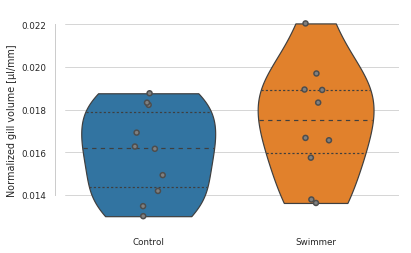

In [162]:
# Boxplot of the NORMALIZED gill volumes
seaborn.violinplot(data=Data, x='Experiment', y='VolumeGillsNormalized', cut=0, inner='quartiles')
# seaborn.boxplot(data=Data, x='Experiment', y='VolumeGillsNormalized')
seaborn.stripplot(data=Data, x='Experiment', y='VolumeGillsNormalized',
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  color='gray')
label = False
if label:
    shift = 0.05
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c],
                               (0 + shift * numpy.random.rand(),
                                Data.VolumeGillsNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')
        else:
            plt.gca().annotate(Data.Sample[c],
                               (1 + shift * numpy.random.rand(),
                                Data.VolumeGillsNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')
# plt.title('Normalized gill volume (normalized to fish length)')
# plt.ylim(ymax=Data.VolumeGillsNormalized.max() * 1.2)
plt.xlabel('')
plt.ylabel(u'Normalized gill volume [\u03bcl/mm]')  # https://stackoverflow.com/a/2140991/323100
# significance_bar(0, 1,
#                  Data.VolumeGillsNormalized.max(),
#                  p_value_volume_normalized)
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
if label:
    plt.savefig(os.path.join(OutPutDir,
                             'Volume_Gills_Normalized_ul_from%04dslices.png' % NumberOfImagesToShow),
                bbox_inches='tight')
else:
    plt.savefig(os.path.join(OutPutDir,
                             'Volume_Gills_Normalized_ul_from%04slies_nolabels.png' % NumberOfImagesToShow),
                bbox_inches='tight')
plt.show()

In [163]:
# Data as prose
for experiment in Data.Experiment.unique():
    print('The %s fishes have a normalized gill volume '
          'of %0.2g mm^3/mm' % (experiment,
                                Data[Data.Experiment == experiment]['VolumeGillsNormalized'].mean()))
print('This is an increase of %0.2f %%' % percentage(Data['VolumeGillsNormalized'][Data.Experiment == 'Control'].mean(),
                                                     Data['VolumeGillsNormalized'][Data.Experiment == 'Swimmer'].mean()))

The Control fishes have a normalized gill volume of 0.016 mm^3/mm
The Swimmer fishes have a normalized gill volume of 0.017 mm^3/mm
This is an increase of 8.78 %


----
# Gills per organ

In [164]:
# Shapiro -> Normalitätstest
scipy.stats.shapiro(Data.Mean_Gill_Ratio)
# nicht signifikant von Normalverteilung unterschiedlich

(0.9723851680755615, 0.8042409420013428)

In [165]:
# Levene -> Varianztest
scipy.stats.levene(Data.loc[Data.Experiment == 'Control'].Mean_Gill_Ratio,
                   Data.loc[Data.Experiment == 'Swimmer'].Mean_Gill_Ratio)
# nicht signifikant -> Wahrscheinlich nicht nicht normalverteilt

LeveneResult(statistic=0.5030873216370878, pvalue=0.487233264429611)

In [166]:
# Compute the Kolmogorov-Smirnov statistic on 2 samples -> Verteilungen nicht unterschiedlich?
scipy.stats.ks_2samp(Data.loc[Data.Experiment == 'Control'].Mean_Gill_Ratio,
                     Data.loc[Data.Experiment == 'Swimmer'].Mean_Gill_Ratio)
# nicht signifikant -> wahrscheinlich nicht unterschiedliche Verteilung --> equal_var=True

Ks_2sampResult(statistic=0.7, pvalue=0.006898647100946128)

In [167]:
# Are the means different?
t_statistic, p_value_area = scipy.stats.ttest_ind(Data.loc[Data.Experiment == 'Control'].Mean_Gill_Ratio,
                                                  Data.loc[Data.Experiment == 'Swimmer'].Mean_Gill_Ratio,
                                                  equal_var=True)
print("The difference between the 'Mean_Gill_Ratio' of 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
p_value_area /= 2
print('F value of %0.4s and a p value of %.2g (%s).' % (t_statistic,
                                                        p_value_area,
                                                        significance(p_value_area)))

The difference between the 'Mean_Gill_Ratio' of 'Control' and 'Swimmer' has an
F value of 2.61 and a p value of 0.0088 (**).


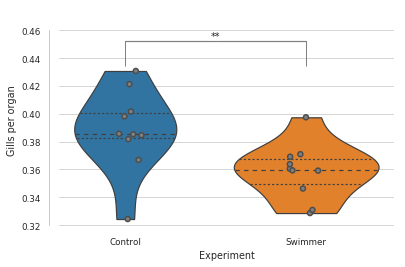

In [168]:
# Boxplot of the mean area for each animal (calculated slice-wise)
seaborn.violinplot(data=Data, x='Experiment', y='Mean_Gill_Ratio', cut=0, inner='quartiles')
seaborn.stripplot(data=Data, x='Experiment', y='Mean_Gill_Ratio',
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  color='gray')
label = False
if label:
    shift = 0.1
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.Mean_Gill_Ratio[c]),
                               horizontalalignment='left', verticalalignment='bottom')
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.Mean_Gill_Ratio[c]),
                               horizontalalignment='left', verticalalignment='bottom')
# plt.title('Average "gills per organ" from slices')
plt.ylim(ymax=Data.Mean_Gill_Ratio.max() * 1.1)
plt.ylabel('Gills per organ')
significance_bar(0, 1,
                 Data.Mean_Gill_Ratio.max(),
                 p_value_area)
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir,
                         'Gills_per_organ_average_slices_from%04dslices.png' % NumberOfImagesToShow),
            bbox_inches='tight')
plt.show()

In [169]:
# Data as prose
for experiment in Data.Experiment.unique():
    print('The %s fishes have a mean gill ratio of '
          'of %0.1f %% with a STD of %0.1f' % (experiment,
                                               Data[Data.Experiment == experiment]['Mean_Gill_Ratio'].mean() * 100,
                                               Data[Data.Experiment == experiment]['Mean_Gill_Ratio'].std() * 100))
print('This is an decrease of %0.1f %%' % percentage(Data['Mean_Gill_Ratio'][Data.Experiment == 'Swimmer'].mean(),
                                                     Data['Mean_Gill_Ratio'][Data.Experiment == 'Control'].mean()))

The Control fishes have a mean gill ratio of of 38.8 % with a STD of 2.9
The Swimmer fishes have a mean gill ratio of of 35.9 % with a STD of 2.0
This is an decrease of 8.2 %


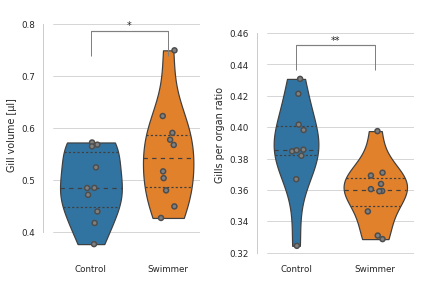

In [170]:
# Plot both the gills volume and gills per organ ratio 
plt.subplot(121)
bars = seaborn.violinplot(data=Data, x='Experiment', y='VolumeGills_ul', cut=0, inner='quartiles')
# bars = seaborn.boxplot(data=Data, x='Experiment', y='VolumeGills_ul')
seaborn.stripplot(data=Data, x='Experiment', y='VolumeGills_ul',
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  color='gray')
label = False
if label:
    shift = 0.05
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c],
                               (0 + shift * numpy.random.rand(),
                                Data.VolumeGills_ul[c]),
                               horizontalalignment='left', verticalalignment='bottom')
        else:
            plt.gca().annotate(Data.Sample[c],
                               (1 + shift * numpy.random.rand(),
                                Data.VolumeGills_ul[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.xlabel('')
plt.ylabel(u'Gill volume [\u03bcl]')  # https://stackoverflow.com/a/2140991/323100
plt.ylim(ymax=Data.VolumeGills_ul.max() * 1.1)
significance_bar(0, 1,
                 Data.VolumeGills_ul.max(),
                 p_value_volume)
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.subplot(122)
seaborn.violinplot(data=Data, x='Experiment', y='Mean_Gill_Ratio', cut=0, inner='quartiles')
seaborn.stripplot(data=Data, x='Experiment', y='Mean_Gill_Ratio',
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  color='gray')
label = False
if label:
    shift = 0.1
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.Mean_Gill_Ratio[c]),
                               horizontalalignment='left', verticalalignment='bottom')
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.Mean_Gill_Ratio[c]),
                               horizontalalignment='left', verticalalignment='bottom')
# plt.title('Average "gills per organ" from slices')
plt.xlabel('')
plt.ylim(ymax=Data.Mean_Gill_Ratio.max() * 1.1)
plt.ylabel('Gills per organ ratio')
significance_bar(0, 1,
                 Data.Mean_Gill_Ratio.max(),
                 p_value_area)
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir,
                         'GillVolume.GillRatio.png' % NumberOfImagesToShow),
            bbox_inches='tight')
plt.show()

----
# Respirometry

In [171]:
# What do we have?
for training in Respirometry.Training.unique():
    for exp in Respirometry.Experiment.unique():
            print('%s\t%s\tmean O2 consumption '
                  'of %s fishes: %0.4f' % (exp,
                                           training,
                                           len(Respirometry[(Respirometry['Experiment'] == exp) &
                                                            (Respirometry['Training'] == training)]['o2'].dropna()),
                                           Respirometry[(Respirometry['Experiment'] == exp) &
                                                                        (Respirometry['Training'] == training) ]['o2'].dropna().mean()))

Control	Before	mean O2 consumption of 10 fishes: 0.0345
Swimmer	Before	mean O2 consumption of 10 fishes: 0.0334
Control	After	mean O2 consumption of 10 fishes: 0.0263
Swimmer	After	mean O2 consumption of 9 fishes: 0.0343


In [172]:
p_value_respirometry = [None] * 4

In [173]:
# Are there differences between control and swimmers?
for c, training in enumerate(Morphology.Training.unique()):
    print(80 * '-')
    t_statistic, p_value_respirometry[c] = scipy.stats.ttest_ind(Respirometry[(Respirometry.Training == training)
                                                                              & (Respirometry.Experiment == 'Control')].o2.dropna(),
                                                                 Respirometry[(Respirometry.Training == training)
                                                                              & (Respirometry.Experiment == 'Swimmer')].o2.dropna(),
                                                                 equal_var=True)
    print("At %s, the 'o2' for 'Control' and 'Swimmer' have a" % training)
    # Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
    p_value_respirometry[c] /= 2
    print('F value of %0.4s and a p value of %.2g (%s).' % (t_statistic,
                                                            p_value_respirometry[c],
                                                            significance(p_value_respirometry[c])))

--------------------------------------------------------------------------------
At Before, the 'o2' for 'Control' and 'Swimmer' have a
F value of 0.19 and a p value of 0.42 (n.s.).
--------------------------------------------------------------------------------
At After, the 'o2' for 'Control' and 'Swimmer' have a
F value of -2.6 and a p value of 0.0081 (**).


In [174]:
# Are the 02 consumptions between trainings different?
for c, experiment in enumerate(Respirometry.Experiment.unique()):
    for trainings in itertools.combinations(Respirometry.Training.unique(), 2):
        print(80 * '-')
        t_statistic, p_value_respirometry[c + 2] = scipy.stats.ttest_ind(Respirometry[(Respirometry.Training == trainings[0])
                                                                                      & (Respirometry.Experiment == experiment)].o2.dropna(),
                                                                         Respirometry[(Respirometry.Training == trainings[1])
                                                                                      & (Respirometry.Experiment == experiment)].o2.dropna(),
                                                                         equal_var=True)
        print("For the %s group, the '02' between '%s' and '%s' has an" % (experiment,
                                                                           trainings[0],
                                                                           trainings[1]))
        # Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
        p_value_respirometry[c + 2] /= 2
        print('F value of %0.4s and a p value of %.2g. (%s)' % (t_statistic,
                                                                p_value_respirometry[c + 2],
                                                                significance(p_value_respirometry[c + 2])))

--------------------------------------------------------------------------------
For the Control group, the '02' between 'Before' and 'After' has an
F value of 1.70 and a p value of 0.053. (n.s.)
--------------------------------------------------------------------------------
For the Swimmer group, the '02' between 'Before' and 'After' has an
F value of -0.2 and a p value of 0.42. (n.s.)


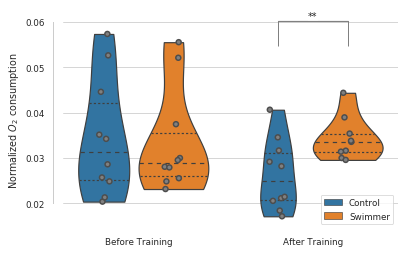

In [175]:
# Display respirometry data
seaborn.violinplot(data=Respirometry, hue='Experiment', y='o2', x='Training', cut=0, inner='quartiles')
# seaborn.boxplot(data=Respirometry, hue='Experiment', y='o2', x='Training', showfliers=False, notch=True)
seaborn.stripplot(data=Respirometry, hue='Experiment', y='o2', x='Training',
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  palette=['gray', 'gray'])
if legend:
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:len(handles) // 2],
               labels[:len(labels) // 2],
               loc='lower right')
else:
    plt.legend().set_visible(False)
plt.xlabel('')
plt.gca().set_xticklabels(['Before Training', 'After Training'])
plt.ylabel('Normalized $O_{2}$ consumption')
significance_bar(1 - 0.2, 1 + 0.2,
                 Respirometry['o2'].max(),
                 p_value_respirometry[1])
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir, 'O2_normalized.png'), bbox_inches='tight')
plt.show()

In [176]:
for experiment in Data.Experiment.unique():
    print('The normalized O2 consumption for '
          'the %s group at start was '
          '%0.3f with a STD of %0.3f.' % (experiment,
                                          Data[Data.Experiment == experiment]['O2 consumption start normalized'].mean(),
                                          Data[Data.Experiment == experiment]['O2 consumption start normalized'].std()))

The normalized O2 consumption for the Control group at start was 0.034 with a STD of 0.013.
The normalized O2 consumption for the Swimmer group at start was 0.033 with a STD of 0.011.


In [177]:
print('This is an increase (Swimmer to Control) '
      'of %0.2f %%' % percentage(Data[Data.Experiment == 'Swimmer']['O2 consumption start normalized'].mean(),
                                 Data[Data.Experiment == 'Control']['O2 consumption start normalized'].mean()))

This is an increase (Swimmer to Control) of 3.18 %


In [178]:
for experiment in Data.Experiment.unique():
    print('The normalized O2 consumption for '
          'the %s group at end was '
          '%0.3f with a STD of %0.3f.' % (experiment,
                                          Data[Data.Experiment == experiment]['O2 consumption end normalized'].mean(),
                                          Data[Data.Experiment == experiment]['O2 consumption end normalized'].std()))

The normalized O2 consumption for the Control group at end was 0.026 with a STD of 0.008.
The normalized O2 consumption for the Swimmer group at end was 0.034 with a STD of 0.005.


In [179]:
print('This is an increase (Control to Swimmer) '
      'of %0.1f %%' % percentage(Data[Data.Experiment == 'Control']['O2 consumption end normalized'].mean(),
                                 Data[Data.Experiment == 'Swimmer']['O2 consumption end normalized'].mean()))

This is an increase (Control to Swimmer) of 30.4 %


In [180]:
for experiment in Data.Experiment.unique():
    print('Increase of %s (start to end) '
          'is %0.1f %%' % (experiment,
                           percentage(Data[Data.Experiment == experiment]['O2 consumption start normalized'].mean(),
                                      Data[Data.Experiment == experiment]['O2 consumption end normalized'].mean())))

Increase of Control (start to end) is -23.7 %
Increase of Swimmer (start to end) is 2.6 %


# Mitosis

In [181]:
# Shapiro -> Normalitätstest
scipy.stats.shapiro(Mitoses['M_per_N'])
# nicht signifikant von Normalverteilung unterschiedlich

(0.9556111097335815, 0.06711876392364502)

In [182]:
# Levene -> Varianztest
scipy.stats.levene(Mitoses.loc[Mitoses.Experiment == 'Control']['M_per_N'],
                   Mitoses.loc[Mitoses.Experiment == 'Swimmer']['M_per_N'])
# nicht signifikant -> Wahrscheinlich nicht nicht normalverteilt

LeveneResult(statistic=2.9606547345301877, pvalue=0.09203445116762717)

In [183]:
# Compute the Kolmogorov-Smirnov statistic on 2 samples -> Verteilungen nicht unterschiedlich?
scipy.stats.ks_2samp(Mitoses.loc[Mitoses.Experiment == 'Control']['M_per_N'],
                     Mitoses.loc[Mitoses.Experiment == 'Swimmer']['M_per_N'])
# nicht signifikant -> wahrscheinlich nicht unterschiedliche Verteilung --> equal_var=True

Ks_2sampResult(statistic=0.33333333333333337, pvalue=0.1094330857250145)

In [184]:
# Are the means different?
t_statistic, p_value_mitosis = scipy.stats.ttest_ind(Mitoses.loc[Mitoses.Experiment == 'Control']['M_per_N'],
                                                     Mitoses.loc[Mitoses.Experiment == 'Swimmer']['M_per_N'],
                                                     equal_var=True)
print("The mean mitosis per nucleus of 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
p_value_mitosis /= 2
print('F value of %0.4s and a p value of %.2g (%s).' % (t_statistic,
                                                        p_value_mitosis,
                                                        significance(p_value_mitosis)))

The mean mitosis per nucleus of 'Control' and 'Swimmer' has an
F value of -2.5 and a p value of 0.0074 (**).


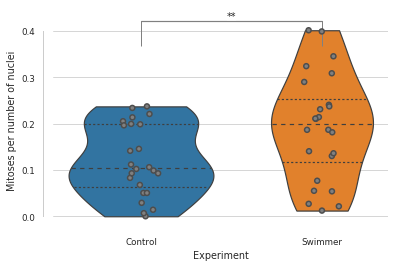

In [185]:
seaborn.violinplot(data=Mitoses,
                   x=Mitoses['Experiment'],
                   y=Mitoses['M_per_N'],
                   cut=0,
                   inner='quartiles')
seaborn.stripplot(data=Mitoses,
                  x=Mitoses['Experiment'],
                  y=Mitoses['M_per_N'],
                  jitter=True,
                  s=5,
                  linewidth=1.5,
                  color='gray')
significance_bar(0, 1,
                 numpy.max(Mitoses['M_per_N'].max()),
                 p_value_mitosis)
plt.ylabel('Mitoses per number of nuclei')
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir,
                         'Mitoses.png'),
            bbox_inches='tight')
plt.show()

In [186]:
# Data as prose
for experiment in Mitoses.Experiment.unique():
    print('The mitoses per nuclei of the %s fishes '
          'are %0.2f with a STD of %0.2f' % (experiment,
                                             Mitoses[Mitoses.Experiment == experiment]['M_per_N'].mean(),
                                             Mitoses[Mitoses.Experiment == experiment]['M_per_N'].std()))
print('This is an increase of %0.1f %%' % percentage(Mitoses['M_per_N'][Mitoses.Experiment == 'Control'].mean(),
                                                     Mitoses['M_per_N'][Mitoses.Experiment == 'Swimmer'].mean()))

The mitoses per nuclei of the Control fishes are 0.12 with a STD of 0.08
The mitoses per nuclei of the Swimmer fishes are 0.19 with a STD of 0.12
This is an increase of 59.5 %


----
We are done!

In [187]:
# Save data at the end
Data.to_csv('Data_%s.csv' % get_git_hash())
Data.to_csv(os.path.join(OutPutDir,
                         'Data_%s.csv' % get_git_hash()))
# Speed.to_csv('Speed_%s.csv' % get_git_hash())
Speed.to_csv(os.path.join(OutPutDir,
                          'Speed_%s.csv' % get_git_hash()))
# Morphology.to_csv('Morphology_%s.csv' % get_git_hash())
Morphology.to_csv(os.path.join(OutPutDir,
                               'Morphology_%s.csv' % get_git_hash()))
# Filaments.to_csv('Filaments_%s.csv' % get_git_hash())
Filaments.to_csv(os.path.join(OutPutDir,
                              'Filaments_%s.csv' % get_git_hash()))
# Respirometry.to_csv('Respirometry_%s.csv' % get_git_hash())
Respirometry.to_csv(os.path.join(OutPutDir,
                                 'Respirometry_%s.csv' % get_git_hash()))
# Respirometry.to_csv('Respirometry_%s.csv' % get_git_hash())
Mitoses.to_csv(os.path.join(OutPutDir,
                            'Mitoses_%s.csv' % get_git_hash()))

In [188]:
print('All data has been saved to %s' % os.path.join(OutPutDir))

All data has been saved to /home/habi/P/Documents/Zebrafish-Gills/Output/99a07e1


In [189]:
print('Done!')

Done!


----

# Collect images for the figures in the manuscript

In [190]:
def image_label(image, labeltext):
    '''We have to print a label over the image several times'''
    plt.gca().text(numpy.shape(image)[0]*0.0309, numpy.shape(image)[1] * 0.0309,
               labeltext, color='white', fontsize=12, fontweight='bold',
               verticalalignment='top', horizontalalignment='left')
    return

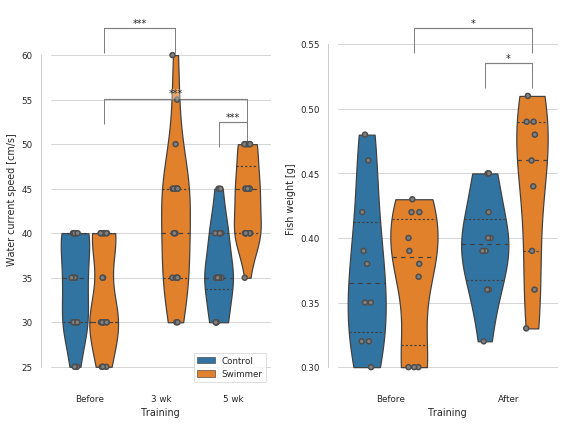

In [191]:
# Fig01: swim performance+body weight: one panel
plt.rcParams['figure.figsize'] = (8, 6)
plt.subplot(121)
seaborn.violinplot(data=Speed, hue='Experiment', y='WaterSpeed', x='Training', cut=0, inner='quartiles')
seaborn.stripplot(data=Speed, hue='Experiment', y='WaterSpeed', x='Training',
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  palette=['gray', 'gray'])
legend = True
if legend:
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:len(handles) // 2],
               labels[:len(labels) // 2],
               loc='lower right')
else:
    plt.legend().set_visible(False)
plt.ylabel('Water current speed [cm/s]')    
significance_bar(0 + 0.2,
                 1 + 0.2,
                 numpy.maximum(Speed[(Speed.Experiment == 'Swimmer')
                                     & (Speed.Training == 'Before')].WaterSpeed.max(),
                               Speed[(Speed.Experiment == 'Swimmer')
                                     & (Speed.Training == '3 wk')].WaterSpeed.max()),
                 p_values_training['Swimmer'][-3])
significance_bar(2 - 0.2,
                 2 + 0.2,
                 Speed[(Speed.Training == '5 wk')].WaterSpeed.max(),
                 p_values_training['Control vs. Swimmer']['5 wk'])
significance_bar(0 + 0.2,
                 2 + 0.2,
                 1.05 * numpy.maximum(Speed[(Speed.Experiment == 'Swimmer')
                                            & (Speed.Training == 'Before')].WaterSpeed.max(),
                                      Speed[(Speed.Experiment == 'Swimmer')
                                            & (Speed.Training == '5 wk')].WaterSpeed.max()),
                 p_values_training['Swimmer'][-2])
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.subplot(122)
# Display male fish weight
seaborn.violinplot(data=Morphology[Morphology.Gender == 'Male'], hue='Experiment', y='Weight', x='Training',
                   cut=0, inner='quartiles')
seaborn.stripplot(data=Morphology[Morphology.Gender == 'Male'], hue='Experiment', y='Weight', x='Training',
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  palette=['gray', 'gray'])
legend=False
if legend:
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:len(handles) // 2],
               labels[:len(labels) // 2],
               loc='upper left')
else:
    plt.legend().set_visible(False)
plt.xlabel('Training')
plt.gca().set_xticklabels(['Before',
                           'After'])
plt.ylabel('Fish weight [g]')
significance_bar(1 - 0.2,
                 1 + 0.2,
                 Morphology[(Morphology.Gender == 'Male')
                            & (Morphology.Training == 'After')].Weight.max(),
                 p_values_weight[1])
significance_bar(0 + 0.2,
                 1 + 0.2,
                 1.05 * Morphology[(Morphology.Gender == 'Male')
                                   & (Morphology.Experiment == 'Swimmer')].Weight.max(),
                 p_values_weight[-1])
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir,
                         'Fig01.png'),
            bbox_inches = 'tight',
            pad_inches = 0)
plt.show()

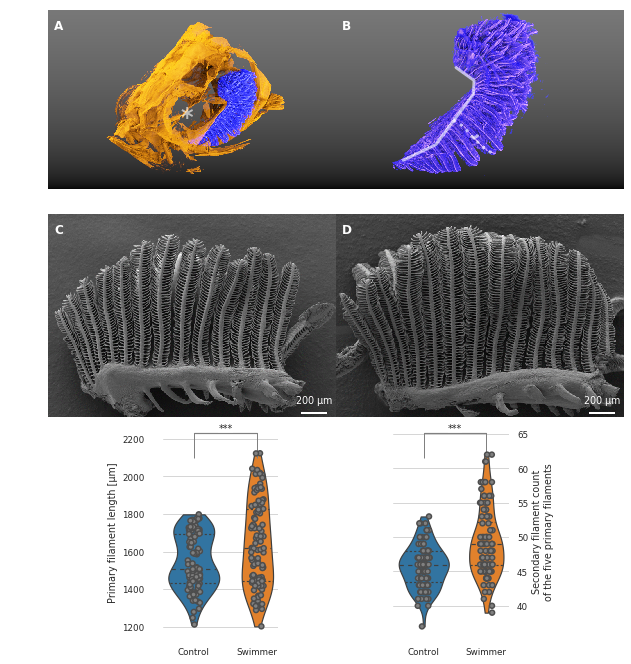

In [192]:
# Fig 02:then anatomy of the gills (panel of new David's figures) AND SEM gill overview whole arches and the quantification: no. and length of filaments: one panel
shift = 50
plt.rcParams['figure.figsize'] = (8, 9)
plt.subplot(321)
Head = imageio.imread('Figure-Originals/control06.fullhead2.tif')
plt.imshow(Head)
plt.gca().text(894, 689, '*', color='white', fontsize=24, fontweight='bold',
                      verticalalignment='center', horizontalalignment='center', alpha=0.618)
image_label(Head, 'A')
plt.axis('off')
plt.subplot(322)
Gill = imageio.imread('Figure-Originals/control06.gills3.tif')
plt.imshow(Gill)
image_label(Gill, 'B')
x, y = [433, 642, 884, 888, 772], [966, 866, 541, 453, 370]
plt.plot(x, y, marker = None, linewidth=3, color='white', alpha=0.618)
x, y = [753, 794, 830, 868, 964, 1013], [710, 731, 760, 807, 899, 923]
plt.plot(x, y, marker = None, linewidth=3, linestyle='dotted', color='white', alpha=0.618)
x, y = [886, 911], [825, 809]
plt.plot(x, y, marker = None, linewidth=3, color='white', alpha=0.618)
plt.axis('off')
# SEM
plt.subplot(323)
SEM_ctrl = imageio.imread('Figure-Originals/SEM_C5.3_crop.tif')
plt.imshow(SEM_ctrl)
plt.gca().add_artist(ScaleBar(3, 'um'))        
image_label(SEM_ctrl, 'C')
plt.axis('off')
plt.subplot(324)
SEM_swimmer = imageio.imread('Figure-Originals/SEM_S5.3_crop.tif')
plt.imshow(SEM_swimmer)
plt.gca().add_artist(ScaleBar(3, 'um'))
image_label(SEM_swimmer, 'D')
plt.axis('off')
# Display both count and length in the same plot
plt.subplot(3,5,12)
seaborn.violinplot(data=Filaments[['Control Length', 'Swimmer Length']],
                   cut=0, inner='quartiles')
seaborn.stripplot(data=Filaments[['Control Length', 'Swimmer Length']],
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  color='gray')
significance_bar(0, 1,
                 numpy.max(Filaments[['Control Length', 'Swimmer Length']].max()),
                 p_value_filament_length)
plt.ylabel(u'Primary filament length [\u03bcm]')
plt.gca().set_xticklabels(['Control', 'Swimmer'])
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.subplot(3,5,14)
# Display filament count
seaborn.violinplot(data=Filaments[['Control Count', 'Swimmer Count']],
                   cut=0, inner='quartiles')
# seaborn.boxplot(data=Filaments[['Control Count', 'Swimmer Count']], notch=True)
seaborn.stripplot(data=Filaments[['Control Count', 'Swimmer Count']],
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  color='gray')
significance_bar(0,
                 1,
                 numpy.max(Filaments[['Control Count', 'Swimmer Count']].max()),
                 p_value_filament_count)
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position('right')
plt.gca().yaxis.set_ticks_position('none')
plt.ylabel('Secondary filament count\nof the five primary filaments')
plt.gca().set_xticklabels(['Control', 'Swimmer'])
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True,left=True, bottom=True)
plt.subplots_adjust(0,0,1,1,0,0)
plt.savefig(os.path.join(OutPutDir,
                         'Fig02.png'),
            bbox_inches = 'tight',
            pad_inches = 0)
plt.show()

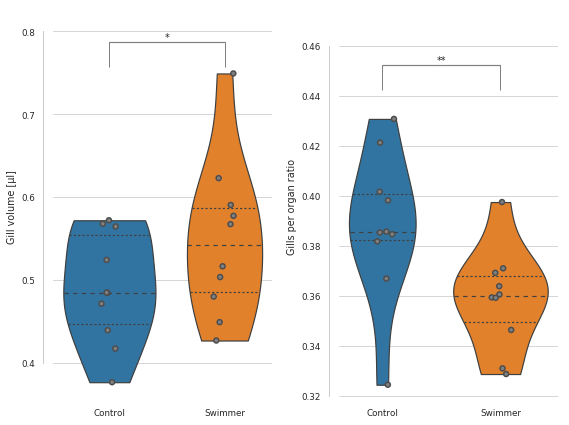

In [193]:
# Fig 03: uCT data, measurement of volumes: quantification of volume and filling factor
plt.rcParams['figure.figsize'] = (8, 6)  # Size up figures a bit
plt.subplot(121)
bars = seaborn.violinplot(data=Data, x='Experiment', y='VolumeGills_ul', cut=0, inner='quartiles')
# bars = seaborn.boxplot(data=Data, x='Experiment', y='VolumeGills_ul')
seaborn.stripplot(data=Data, x='Experiment', y='VolumeGills_ul',
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  color='gray')
label = False
if label:
    shift = 0.05
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c],
                               (0 + shift * numpy.random.rand(),
                                Data.VolumeGills_ul[c]),
                               horizontalalignment='left', verticalalignment='bottom')
        else:
            plt.gca().annotate(Data.Sample[c],
                               (1 + shift * numpy.random.rand(),
                                Data.VolumeGills_ul[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.xlabel('')
plt.ylabel(u'Gill volume [\u03bcl]')  # https://stackoverflow.com/a/2140991/323100
plt.ylim(ymax=Data.VolumeGills_ul.max() * 1.1)
significance_bar(0, 1,
                 Data.VolumeGills_ul.max(),
                 p_value_volume)
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.subplot(122)
seaborn.violinplot(data=Data, x='Experiment', y='Mean_Gill_Ratio', cut=0, inner='quartiles')
seaborn.stripplot(data=Data, x='Experiment', y='Mean_Gill_Ratio',
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  color='gray')
# plt.title('Average "gills per organ" from slices')
plt.xlabel('')
plt.ylim(ymax=Data.Mean_Gill_Ratio.max() * 1.1)
plt.ylabel('Gills per organ ratio')
significance_bar(0, 1,
                 Data.Mean_Gill_Ratio.max(),
                 p_value_area)
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir,
                         'Fig03.png'),
            bbox_inches = 'tight',
            pad_inches = 0)
plt.show()

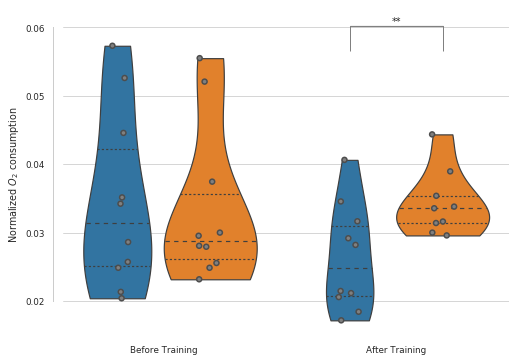

In [194]:
# Fig 04: another panel: respirometry
seaborn.violinplot(data=Respirometry, hue='Experiment', y='o2', x='Training', cut=0, inner='quartiles')
# seaborn.boxplot(data=Respirometry, hue='Experiment', y='o2', x='Training', showfliers=False, notch=True)
seaborn.stripplot(data=Respirometry, hue='Experiment', y='o2', x='Training',
                  jitter=True, dodge=True, s=5, linewidth=1.5,
                  palette=['gray', 'gray'])
if legend:
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:len(handles) // 2],
               labels[:len(labels) // 2],
               loc='lower right')
else:
    plt.legend().set_visible(False)
plt.xlabel('')
plt.gca().set_xticklabels(['Before Training', 'After Training'])
plt.ylabel('Normalized $O_{2}$ consumption')
significance_bar(1 - 0.2, 1 + 0.2,
                 Respirometry['o2'].max(),
                 p_value_respirometry[1])
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir,
                         'Fig04.png'),
            bbox_inches = 'tight',
            pad_inches = 0)
plt.show()

In [195]:
# Load Deas images for Fig05
sprouting = glob.glob(os.path.join('*Originals', '*dea', '*.tif'))

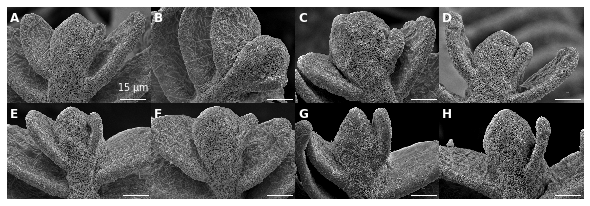

In [196]:
# Fig 05: then budding stages
plt.rcParams['figure.figsize'] = (8,8/3.0)
pixelsize_sprouting = 0.0135  # as measured in ImageJ, from the 40 um scalebar in the originals
for c, img in enumerate(sprouting[1:]):  # The first image is not needed...
    plt.subplot(2,4,c+1)
    img = imageio.imread(img)[:4095,:]  # We crop the bottom of the image containing the SEM information
    if c == 3:
        plt.imshow(numpy.fliplr(img))
    else:
        plt.imshow(img)
    if not c:
        plt.gca().add_artist(ScaleBar(pixelsize_sprouting, 'um'))
    else:
        plt.gca().add_artist(ScaleBar(pixelsize_sprouting, 'um', font_properties={'size':0}))
    image_label(img, string.ascii_uppercase[c])
    plt.gca().set_axis_off()
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(0,0,1,1,0,0)
plt.savefig(os.path.join(OutPutDir, 'Fig05.png'),
            bbox_inches = 'tight',
            pad_inches = 0)
plt.show()

In [197]:
# Load Helenas images for Fig06
# They are the single channels from the tiff files with adapted histogram and saved out as PNG with ImageJ
co1 = glob.glob(os.path.join('*Originals', '*helena', '*paper*', '*_co1_*.png'))
sw5 = glob.glob(os.path.join('*Originals', '*helena', '*paper*', '*_sw5_*.png'))
names = ['DAPI', 'eGFP', 'BrdU', 'Combined']

In [198]:
# Reorder lists, since we would like to have the images in a specific order
# Based on https://stackoverflow.com/a/2177607/323100
order = [2, 1, 0, 3]
co1 = [co1[i] for i in order]
sw5 = [sw5[i] for i in order]

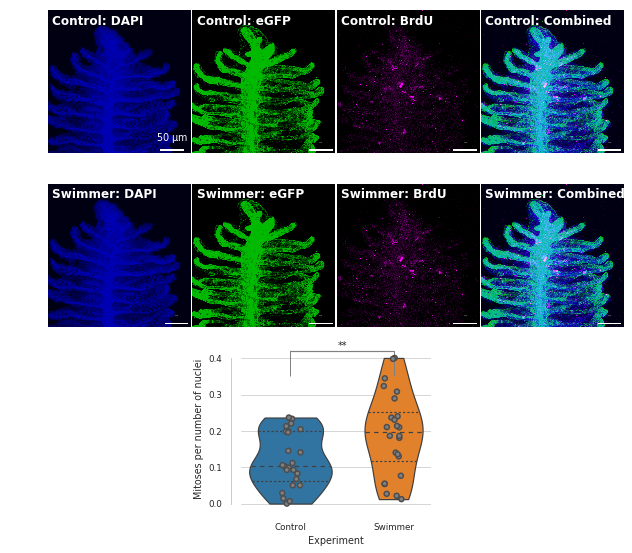

In [199]:
# Fig06: last panel: quantification of mitoses: confocal panel and graph, the 'overview' figure I'll delete it was still just provisory
plt.rcParams['figure.figsize'] = (8, 8)
pixelsize_confocal = 0.2020
for panel in range(4):
    plt.subplot(3,4,panel+1)
    img = imageio.imread(co1[panel])
    plt.imshow(img)
    image_label(img, 'Control: ' + names[panel])
    if not panel:
        plt.gca().add_artist(ScaleBar(pixelsize_confocal, 'um'))
    else:
        plt.gca().add_artist(ScaleBar(pixelsize_confocal, 'um', font_properties={'size':0}))
    plt.gca().set_axis_off()
    plt.margins(0,0)
#     plt.gca().xaxis.set_major_locator(plt.NullLocator())
#     plt.gca().yaxis.set_major_locator(plt.NullLocator())
for panel in range(4):
    plt.subplot(3,4,4+panel+1)
    img = imageio.imread(co1[panel])
    plt.imshow(img)
    image_label(img, 'Swimmer: ' + names[panel])
    plt.gca().add_artist(ScaleBar(pixelsize_confocal, 'um', font_properties={'size':0}))
    plt.gca().set_axis_off()
    plt.margins(0,0)
#     plt.gca().xaxis.set_major_locator(plt.NullLocator())
#     plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplot(338)
seaborn.violinplot(data=Mitoses,
                   x=Mitoses['Experiment'],
                   y=Mitoses['M_per_N'],
                   cut=0,
                   inner='quartiles')
seaborn.stripplot(data=Mitoses,
                  x=Mitoses['Experiment'],
                  y=Mitoses['M_per_N'],
                  jitter=True,
                  s=5,
                  linewidth=1.5,
                  color='gray')
significance_bar(0, 1,
                 numpy.max(Mitoses['M_per_N'].max()),
                 p_value_mitosis)
plt.ylabel('Mitoses per number of nuclei')
if zerotheplots:
    plt.ylim(ymin=0)
seaborn.despine(offset=10, trim=True, bottom=True)
plt.subplots_adjust(top = .9, bottom = 0,
                    right = 1, left = 0, 
                    hspace = 0.01, wspace = 0.01)
plt.savefig(os.path.join(OutPutDir,
                         'Fig06.png'),
            bbox_inches = 'tight',
            pad_inches = 0)
plt.show()

In [200]:
print(OutPutDir)

/home/habi/P/Documents/Zebrafish-Gills/Output/99a07e1
